# Práctica 1: Análisis y Limpieza de datos

**Integrantes:**

> Cruz Larios Marcela

> Fragoso Alavardo Daniel

> Ayala Salcedo Marlene Viviane

> Gómez Martínez Jesús Enrique 

> Rangel Ramírez Hugo

# Librerias

In [178]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [179]:
!pip install py_stringmatching
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [180]:
#Se importan las librerías que se iran usando a lo largo de la libreta para realizar transformaciones, limpieza y preprocesamiento
import pandas as pd
import numpy as np
import random
import unicodedata
import re

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import datetime
from datetime import date
import calendar
from IPython.display import HTML
from plotly.offline import plot,iplot
import matplotlib.pyplot as plt
import seaborn as sns
# pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.express as px #graficos express

In [181]:
#Librerías que nos ayudarán a mostrar ciertas visualizaciones
import cufflinks as cf
pd.set_option("display.max_columns",200)
pd.set_option('display.max_rows', 200)
warnings.filterwarnings("ignore")
cf.go_offline()

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid', font_scale=0.8)

SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Librerías que traen modelos preestablecidos de ML que ayudan en la preparacion de los datos
!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import chisquare
from scipy import stats
from  functools import reduce
from scipy.stats import ksone
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Funciones

Primero se colocan las funciones preestablecidas proporcionadas en la plantilla de la clase que podrán ser utilizadas a lo largo de la práctica conforme se vayan requiriendo

## Calidad de Datos

In [182]:
#Se crea una función para verificar la completitud de las variables de la base.
def completitud(df):
    comple=pd.DataFrame(df.isnull().sum())
    comple.reset_index(inplace=True)
    comple=comple.rename(columns={"index":"columna",0:"total"})
    comple["completitud"]=(1-comple["total"]/df.shape[0])*100
    comple=comple.sort_values(by="completitud",ascending=True)
    comple.reset_index(drop=True,inplace=True)
    return comple

#Se crea una función en la cual se homologuen los simbolos de las variables de texto.
def clean_text(text, pattern="[^a-zA-Z0-9 ]"):
    cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    cleaned_text = re.sub(pattern, " ", cleaned_text.decode("ascii"), flags=re.UNICODE)
    cleaned_text = u' '.join(cleaned_text.lower().strip().split())
    return cleaned_text

# Función que convierte las fechas formato 'Jan-1999' a formato '1999-01'
def transform_date(date_string):
  if pd.isna(date_string):
    return date_string
  month_map = {'Jan':'01', 'Feb':'02', 'Mar':'03',
               'Apr':'04', 'May':'05', 'Jun':'06',
               'Jul':'07', 'Aug':'08', 'Sep':'09',
               'Oct':'10', 'Nov':'11', 'Dec':'12'}
  month = month_map[date_string[:3]]
  year = date_string[-4:]
  return year + '-' + month

## Gráficas

In [183]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [184]:
def cross_grafica(df,variable,nombre_variable, variable_tgt):
    v_variables_new_by_loan_status = pd.crosstab(df[variable],df[variable_tgt])
    v_variables_new_by_loan_status_index = list(v_variables_new_by_loan_status.index)
    #valores
    malos = list(v_variables_new_by_loan_status.iloc[:,0])  
    buenos = list(v_variables_new_by_loan_status.iloc[:,1])

  #Configuraciones de la grafica
    plt.figure(figsize=(10,5))
  ## Se crean las primeras barras
    plt.bar(v_variables_new_by_loan_status_index, malos, label='Charged Off', color = "grey")
    
  ## Se crean las segundas barras y se apilan sobre las primeras
    plt.bar(v_variables_new_by_loan_status_index, buenos, label='Fully Paid', color='#fca311', bottom=malos)
    plt.xticks(v_variables_new_by_loan_status_index, v_variables_new_by_loan_status_index) #indice y grupos en este caso es lo mismo (indice el numero de grupos y grupos las etiquetas)
    plt.ylabel("Frequency")
    plt.xlabel(nombre_variable)
    plt.title('Distribución de ' + nombre_variable )
    plt.legend()
    # plt.savefig(v_variables_new[i]+".png")
    plt.show()

In [185]:
def cross_grafica_date(df,variable,nombre_variable, variable_tgt):
    v_variables_new_by_loan_status = pd.crosstab(df[variable],df[variable_tgt])
    v_variables_new_by_loan_status_index = list(v_variables_new_by_loan_status.index)
    #valores
    malos = list(v_variables_new_by_loan_status.iloc[:,0])  
    buenos = list(v_variables_new_by_loan_status.iloc[:,1])

  #Configuraciones de la grafica
    plt.figure(figsize=(25,8))
    ax = plt.gca()
    ax.set_xticklabels(ax.get_xticks(), rotation = 90)

  ## Se crean las primeras barras
    plt.bar(v_variables_new_by_loan_status_index, malos, label='Charged Off', color = "grey")
    
  ## Se crean las segundas barras y se apilan sobre las primeras
    plt.bar(v_variables_new_by_loan_status_index, buenos, label='Fully Paid', color='#fca311', bottom=malos)
    plt.xticks(v_variables_new_by_loan_status_index, v_variables_new_by_loan_status_index) #indice y grupos en este caso es lo mismo (indice el numero de grupos y grupos las etiquetas)
    plt.ylabel("Frequency")
    plt.xlabel(nombre_variable)
    plt.title('Distribución de ' + nombre_variable )
    plt.legend()
    # plt.savefig(v_variables_new[i]+".png")
    plt.show()

In [186]:
def grafica_var(df, variable, titulo_variable, variable_objetivo, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - variable is the variable name in the dataframe
    - titulo_variable is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan status
    if continuous:
        sns.distplot(df.loc[df[variable].notnull(), variable], kde=False, ax=ax1)
    else:
        sns.countplot(df[variable], order=sorted(df[variable].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(titulo_variable)
    ax1.set_ylabel('Count')
    ax1.set_title('Distribución de ' + titulo_variable)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=variable, y=variable_objetivo, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(titulo_variable + ' by Loan Status')
    else:
        charge_off_rates = df.groupby(variable)[variable_objetivo].value_counts(normalize=True).loc[:,'charged off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + titulo_variable)
    ax2.set_xlabel(titulo_variable)
    
    plt.tight_layout()

## Missings

In [187]:
def T_E(train, test, columns):
    
    target = list(train.filter(like = 'tgt').columns)[0]
    
    variables_disc = []
    variables_v = []
    variables_c = []

    dic = {}
    iv = []    

    for col in columns:
        if col[0] == 'c':
            variables_c.append(col)
            variables_v.append('v'+col[1:])
            variables_disc.append(col[2:])
        elif col[0] == 'v':
            variables_v.append(col)
            
    for col in variables_c:
        i = 1
        suma = 0
        while i-1 == suma:
            suma = sum(pd.cut(train[col], bins = i).value_counts(1) >= 0.05)
            i += 1  

        train['v' + col[1:]] = pd.cut(train[col], bins = i-1).astype(str)
        
        if col[2:] in variables_disc:
            continue

    # Missings
    for col in variables_v:
        p = pd.DataFrame()
        train[col] = train[col].astype(str).replace({"nan":"Missings"})
        
        # WOE
        aux = train[[col, target]].groupby(col).agg(["count","sum"])
        aux["no_evento"] = aux[target,"count"]-aux[target,"sum"]
        aux["evento"] = aux[target,"sum"]
        aux["evento%"] = aux["evento"]/aux["evento"].sum()
        aux["no_evento%"] = aux["no_evento"]/aux["no_evento"].sum()
        aux["WOE"]=np.log(aux["evento%"]/aux["no_evento%"])
        aux["IV"]=(aux["evento%"]-aux["no_evento%"])*aux["WOE"]
        iv.append(round(aux["IV"].sum(), 5))
        aux = aux[["WOE"]].reset_index().rename(columns={"WOE":"W"+col[1:]})
        train = train.merge(aux,on=col, how="left")
        
        dic[col] = dict(zip(aux[col], aux["W"+col[1:]]))
       
        if col[2:] in variables_disc:
            for i in range(aux[col].shape[0]):
                intervalo = aux.iloc[i,0]
                
                if intervalo == 'Missings':
                    
                    test["W"+col[1:]].replace(to_replace = ['nan'], value = aux.iloc[i,1], inplace = True)
                    
                    
                else:
                    
                    inf = float(intervalo.split(',')[0][1:])
                    sup = float(intervalo.split(',')[1].strip()[0:-1])
                    
                    test[col] = np.where(test['c'+col[1:]].astype(float).between(inf, sup), intervalo, 'Missings')
                    test["W"+col[1:]] = np.where(test['c'+col[1:]].between(inf, sup), aux.iloc[i,1], 'nan')
                            
        else:
            test[col] = test[col].astype(str).replace({"nan":"Missings"})
            test = test.merge(aux,on=col, how="left")
    
    return train, test, dic, pd.DataFrame(zip(variables_v, iv), columns = ['Variables', 'IV'])

## Outliers

In [188]:
def imput_moda(col,df):
  X_train[col].value_counts()
  mode=X_train[col].mode()[0]
#Frecuencias observadas
#Valores
  x_i=X_train[col].fillna(mode).value_counts()
  X_train[col].fillna(mode, inplace = True)
  X_test[col].fillna(mode, inplace = True)
  #comprobación con valos crítico de la distribución
  k=x_i.sum()
  p_i=X_train[col].dropna().value_counts(1)
#Frecuencias teóricas esperadas
  m_i=k*p_i
  chi=chisquare(f_obs=x_i,f_exp=m_i)
  p_val=chi.pvalue
  alpha=0.05
  if p_val<alpha:
      print("Rechazamos HO(La porporción de categorias es la misma que la general)")
  else:
      print("Aceptamos HO(La porporción de categorias es la misma que la general)")
  return df[col].replace(np.nan,mode)

def c_imput(col,df):
   mean=X_train[col].mean()
   median=X_train[col].median()
   mode=X_train[col].mode()[0]   

   originales_mean=list(df[col].dropna().values)
   imputados_mean=list(df[col].fillna(mean).values)
   s_1=stats.ks_2samp(originales_mean,imputados_mean)
   statistic_1=s_1[0]
   pvalue_1=s_1[1]

   originales_median=list(df[col].dropna().values)
   imputados_median=list(df[col].fillna(median).values)
   s_2=stats.ks_2samp(originales_median,imputados_median)
   statistic_2=s_2[0]
   pvalue_2=s_2[1]

   
   originales_mode=list(df[col].dropna().values)
   imputados_mode=list(df[col].fillna(mode).values)
   s_3=stats.ks_2samp(originales_mode,imputados_mode)
   statistic_3=s_3[0]
   pvalue_3=s_3[1]
   
   ## metodo| p-value | estadistico
   # initialize list of lists
   datos = [['mean', pvalue_1,statistic_1], ['median', pvalue_2,statistic_2], ['mode', pvalue_3,statistic_3]]
 
   # Create the pandas DataFrame
   final_tableu = pd.DataFrame(datos, columns = ['Method', 'p-value','statistic'])

   how=final_tableu.iloc[final_tableu['p-value'].idxmax()]['Method']
   imp=SimpleImputer(missing_values=np.nan,strategy=how)
   imp.fit(X_train[[col]])
   X_train[[col]]=imp.transform(X_train[[col]])
   X_test[[col]]=imp.transform(X_test[[col]])


   print(how)
   print(final_tableu)

In [189]:
#multicolineaidad continuas
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

#Multicolinealidad Categoricas
def multicolinealidad_cate(df,y,threshold=5,only_final_vif=False):
    '''
    Función para calcular el VIF Genralizado, (GVIF, Fox and Monette 1992)
    Las variables no deben de deben de estar transformadas con OneHotEncoder ya que la función lo realiza internamnete.
    Args:
        df
        y
        threshold
        only_final_vif
    
    Returns:
        pandas data frame: a data frame, indexed by factor of the GVIF, GVIF^(1/2Df), VIF^(1/2Df)^2 
    '''

    df_x = df.drop(y,axis=1)
    #Guardamos los nombres de las columnas añadiendo el prefijo

    onehot_list = list(df_x.select_dtypes(include=['category', 'object', 'string']).columns)
    #Generamos las variables dummy 
    
    df_1hot = pd.get_dummies(df_x, drop_first=True, dummy_na=False, prefix_sep='_')


    #Dataframe vacio para guardar los resultados
    gvif_df = pd.DataFrame(columns = ['factor','GVIF','Df','GVIF^(1/2Df)', 'VIF'])

    # Iteramos sobre las columas
    for (columnName, columnData) in df_x.iteritems():
        #Si se generaron las de una columna, es decir la variable tiene más de dos posibilidades utilizamos todas las variables creadas
        
        if columnName in onehot_list:
            X1 = df_1hot.loc[:, df_1hot.columns.str.startswith(columnName)]
            X2 = df_1hot.loc[:, ~df_1hot.columns.str.startswith(columnName)]
        else:
            X1 = df_1hot[[columnName]].values
            X2 = df_1hot.loc[:, df_1hot.columns != columnName].values
        #display(X1)
        # Calculamose gvif
        #A la matriz de correlación de las variables codificadas en caliente del atributo en consideración.
        #B la matriz de correlación de todos los demás atributos del conjunto de datos (uno codificado en dummy y numérico) excluyendo los de A.
        #C la matriz de correlación de las variables consideradas tanto en A como en B.
        #GVIF= (det(A)*det(B))/det(C)
        #display(np.corrcoef(X1, rowvar=False))
        gvif = np.linalg.det(np.array(np.corrcoef(X1, rowvar=False), ndmin=2)) * np.linalg.det(np.corrcoef(X2, rowvar=False)) / np.linalg.det(np.corrcoef(np.append(X1, X2, axis=1), rowvar=False))
        #(GVIF) elevado a (1 / (2 * grados de libertad))
        #Los grados de libertad es 1-n (n=Número de opciones que tiene la variable categorica)
        gvif_12df = np.power(gvif, 1 / (2 * X1.shape[1]))
        gvif_12df_sq = gvif_12df ** 2
        DF =  X1.shape[1]
    

        # 
        new_row = {'factor': columnName, 'GVIF': gvif,'Df':DF, 'GVIF^(1/2Df)': gvif_12df, 'VIF': gvif_12df_sq}
        gvif_df = gvif_df.append(new_row, ignore_index=True)

    gvif_df = gvif_df.set_index('factor')
    if only_final_vif:
        gvif_df_final = gvif_df.drop(['GVIF','Df','GVIF^(1/2Df)'],axis=1)
    else:
        gvif_df_final = gvif_df 
    gvif_filter = gvif_df.loc[gvif_df['VIF'] >= threshold]['VIF'].to_dict()
    if gvif_filter:
        for i in gvif_filter.keys():
            df_x_m = df_x.drop([i],axis=1)
    else:
        df_x_m = df_x
    df_m=pd.concat([df_x_m,df[y]],axis=1)
    return gvif_df_final

# Carga de Datos

### Sobre los Datos

Contamos con información de la empresa Lending Club, la cual es una empresa
estadounidense de préstamos, con sede en San Francisco, California. En esta empresa
los prestatarios pueden acceder fácilmente a préstamos con tasas de interés bajas.
El dataset contiene datos de todos los préstamos emitidos durante el período 2007-2015,
donde contiene el estado actual del préstamo (actual, cancelado, completamente pagado)
y la información de pago más reciente. Las características adicionales incluyen puntajes
de crédito, número de consultas financieras y cobros, entre otros.

**Objetivo:** El objetivo de esa práctica será generar una tabla estructurada y limpia para que en un futuro se pueda predecir cuando un cliente caerá en mora a partir de sus características y comportamiento pasado.



In [190]:
#Leemos nuestra base de datos desde el Drive correspondiente

df = pd.read_csv('/content/drive/MyDrive/Universidad/Ciencia de Datos/7mo Semestre/2023_1-Aprendizaje_Maquina/Practicas/P1/dataset_practica1.csv')
#df = pd.read_csv("/content/drive/MyDrive/Universidad/LCD/2023-1/Aprendizaje_Maquina/dataset_practica1.csv", encoding="utf-8")
#df = pd.read_csv("/content/drive/MyDrive/Ciencia de Datos/Séptimo Semestre/Machine Learning/dataset_practica1.csv", encoding="utf-8")

# Calidad de Datos

In [191]:
# Dimensión inicial de nuestro data frame
df.shape

(887379, 74)

In [192]:
#Se muestran los primeros 3 registros para una breve exploración visual de lo que contiene todo nuestro dataset a nivel campo
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:
# Tipos de Variables:
#(Recordemos al final debemos de obtener un DataFrame con variables númericas únicamente)

df.dtypes

id                               int64
member_id                        int64
loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
url                             object
desc                            object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs              

Como estamos interesados en predecir si el cliente pagará el préstamo en el futuro (fully paid) o se le cancelaría la cuenta por no pagar (charged off), se debe restringir la información solo a esos estatus en la variable loan status (variable objetivo).

In [194]:
#Verificamos los posibles valores para la columna de interés 'loan_status' y procedemos a un primer filtro
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [195]:
#Nos quedamos solo con aquellos valores que nos son de importancia
df_restringido = df[(df['loan_status'] == 'Fully Paid') | (df['loan_status'] == 'Charged Off')]

In [196]:
print("""
Registros totales en base original: {}
Registros despues de restringir: {}

Nos quedamos con el  {:.2f}% de los registros
""".format(df.shape[0], df_restringido.shape[0], 100*df_restringido.shape[0]/df.shape[0])
)


Registros totales en base original: 887379
Registros despues de restringir: 252971

Nos quedamos con el  28.51% de los registros



## Completitud

In [197]:
#Primero, se revisa la completitud de la Base antes de re-etiquetar las variables para así trabajar con menos datos.
#Se decidió que solamente se trabajara con las columnas que superen el umbral de 70% de completitud.
completitud_ = completitud(df_restringido)
colum_elegidas = completitud_[completitud_['completitud' ]>70]['columna'].values
colum_elegidas

array(['total_rev_hi_lim', 'tot_coll_amt', 'tot_cur_bal', 'emp_title',
       'emp_length', 'last_pymnt_d', 'revol_util',
       'collections_12_mths_ex_med', 'last_credit_pull_d', 'title',
       'last_pymnt_amnt', 'policy_code', 'application_type',
       'collection_recovery_fee', 'acc_now_delinq', 'recoveries',
       'total_rec_late_fee', 'total_rec_int', 'id', 'total_pymnt_inv',
       'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'total_rec_prncp', 'pymnt_plan', 'purpose', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc',
       'initial_list_status', 'out_prncp_inv', 'total_pymnt', 'url',
       'out_prncp'], dtype=object)

In [198]:
#Al final de este filtro contamos con 52 columnas que son listadas en la celda anterior.
len(colum_elegidas)

52

In [199]:
#Construimos el DataFrame con solamente esas 52 columnas
df_completitud = df_restringido[colum_elegidas]

In [200]:
# Después de todo el proceso de completitud nuestro dataset tiene la siguiente forma:
df_restringido.shape

(252971, 74)

## Etiquetado de Variables

Bajo nuestro criterio se ha optado por dividir a las columnas en 5 categorías, las cuales se listan y especifican en la siguiente celda y que nos facilitarán su tratamiento. Aunado a esto se cambia el nombre de las columnas con una etiqueta al principio para identificar en que etiqueta han sido asignadas.

In [201]:
# v = Variables enteramente numéricas: Discretas y continuas
# c = Categóricas
# d = Fechas
# t = Texto
# i = No sirve para el modelo o carecen de información relevante.

v = ['tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'revol_util', 
       'collections_12_mths_ex_med',  'open_acc', 'pub_rec', 'total_acc', 'delinq_2yrs',
       'acc_now_delinq', 'inq_last_6mths', 'annual_inc', 'last_pymnt_amnt',
       'collection_recovery_fee', 'total_rec_late_fee',  'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'recoveries', 'dti', 'revol_bal',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'out_prncp']
c = ['emp_length', 'policy_code', 'term', 'application_type',
     'grade', 'home_ownership', 'loan_status', 'purpose', 'zip_code',
     'addr_state', 'initial_list_status', 'pymnt_plan', 'verification_status']
d = ['last_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line', 'issue_d']
t = ['title', 'emp_title']
i = ['id', 'member_id', 'url', 'sub_grade']

new_names_v = {old_name:'v_'+ old_name for old_name in v }
new_names_c = {old_name:'c_'+ old_name for old_name in c }
new_names_t = {old_name:'t_'+ old_name for old_name in t }
new_names_d = {old_name:'d_'+ old_name for old_name in d }

df_etiquetado = df_completitud.rename(columns = new_names_v).rename(columns = new_names_c).rename(columns = new_names_d).rename(columns = new_names_t)

## Limpieza

Primero nos deshacemos de todos los campos categorizados como 'i'

In [202]:
df_etiquetado.drop(i,axis=1,inplace=True)

### Limpieza de Variables Categóricas

Para la limpieza de nuestras variables categóricas, pasamos la función 'clean_text' por todos los registros, homologando el formato en el que están escritas y limpiando impurezas como saltos de línea

In [203]:
for i in new_names_c.values():
  df_etiquetado[i] = df_etiquetado[i].map(lambda x:clean_text(str(x).lower()).replace("\n",""))

In [204]:
#Vemos si alguna variable tiene solo un valor y como se encuentran distribuidos los datos en cada una de ellas

for i in range(0, len(new_names_c.values())):
  print(list(new_names_c.values())[i])
  print(df_etiquetado[list(new_names_c.values())[i]].value_counts(1), "\n")

c_emp_length
10 years    0.303912
1 year      0.149195
2 years     0.093137
3 years     0.080563
5 years     0.071388
4 years     0.064027
6 years     0.058319
7 years     0.055678
8 years     0.046839
nan         0.039123
9 years     0.037819
Name: c_emp_length, dtype: float64 

c_policy_code
1 0    1.0
Name: c_policy_code, dtype: float64 

c_term
36 months    0.777393
60 months    0.222607
Name: c_term, dtype: float64 

c_application_type
individual    0.999996
joint         0.000004
Name: c_application_type, dtype: float64 

c_grade
b    0.300687
c    0.258211
a    0.167197
d    0.160121
e    0.075843
f    0.030280
g    0.007661
Name: c_grade, dtype: float64 

c_home_ownership
mortgage    0.493511
rent        0.418850
own         0.086907
other       0.000557
none        0.000170
any         0.000004
Name: c_home_ownership, dtype: float64 

c_loan_status
fully paid     0.821134
charged off    0.178866
Name: c_loan_status, dtype: float64 

c_purpose
debt consolidation    0.586482
cre

In [205]:
#Eliminamos las que solo tienen un valor y aquellos donde la distribución no es consistente

df_etiquetado = df_etiquetado.drop(columns = ['c_pymnt_plan', 'c_application_type', 'c_policy_code'])

In [206]:
#Eliminamos las secuencias del dict:
for i in ['c_pymnt_plan', 'c_application_type', 'c_policy_code']:
  new_names_c.pop(i[2:])

### Limpieza de Variables Númericas

In [207]:
#Vemos las estadísticas de las variables numericas y para checar su consistencia en distribución.
est_numericas = df_etiquetado.describe(percentiles=np.arange(0.1,1.1,.1))
est_numericas

,v_total_rev_hi_lim,v_tot_coll_amt,v_tot_cur_bal,v_revol_util,v_collections_12_mths_ex_med,v_last_pymnt_amnt,v_collection_recovery_fee,v_acc_now_delinq,v_recoveries,v_total_rec_late_fee,v_total_rec_int,v_total_pymnt_inv,v_loan_amnt,v_funded_amnt,v_funded_amnt_inv,v_int_rate,v_installment,v_annual_inc,v_total_rec_prncp,v_dti,v_delinq_2yrs,v_inq_last_6mths,v_open_acc,v_pub_rec,v_revol_bal,v_total_acc,v_out_prncp_inv,v_total_pymnt,v_out_prncp
count,1.892630e+05,1.892630e+05,1.892630e+05,252772.000000,252915.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,2.529710e+05,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,252971.000000,2.529710e+05,252971.000000,252971.0,252971.000000,252971.0
mean,2.970912e+04,2.038236e+02,1.383312e+05,54.312093,0.006726,6461.736176,16.753292,0.003115,159.335069,0.715611,1946.692415,13511.987257,13562.768855,13522.193749,13429.174497,13.764625,418.112216,7.253825e+04,11502.860871,16.544104,0.249914,0.852485,10.939566,0.143439,1.516798e+04,25.035905,0.0,13609.603960,0.0
std,2.951730e+04,2.110206e+04,1.524367e+05,24.790577,0.089005,7363.831427,114.064409,0.060553,748.094545,5.431223,2065.498673,9484.295464,8131.729531,8109.211388,8127.682956,4.401926,244.933059,5.881181e+04,8339.043499,7.788696,0.740600,1.066875,4.890986,0.436383,1.874300e+04,11.747131,0.0,9483.853558,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500.000000,500.000000,0.000000,5.320000,15.690000,3.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2.000000,0.0,0.000000,0.0
10%,8.200000e+03,0.000000e+00,1.375320e+04,19.200000,0.000000,205.330000,0.000000,0.000000,0.000000,0.000000,275.260000,3236.510000,4700.000000,4650.000000,4487.745568,7.900000,151.020000,3.350000e+04,2040.330000,6.430000,0.000000,0.000000,6.000000,0.000000,2.914000e+03,11.000000,0.0,3334.080000,0.0
20%,1.160000e+04,0.000000e+00,2.339240e+04,31.500000,0.000000,373.170000,0.000000,0.000000,0.000000,0.000000,512.460000,5407.370000,6225.000000,6200.000000,6000.000000,9.760000,207.560000,4.100000e+04,4000.000000,9.490000,0.000000,0.000000,7.000000,0.000000,4.947000e+03,15.000000,0.0,5496.760000,0.0
30%,1.490000e+04,0.000000e+00,3.397660e+04,40.600000,0.000000,654.680000,0.000000,0.000000,0.000000,0.000000,750.240000,7227.460000,8000.000000,8000.000000,8000.000000,11.140000,267.600000,4.803400e+04,6000.000000,11.910000,0.000000,0.000000,8.000000,0.000000,6.789000e+03,18.000000,0.0,7323.647541,0.0
40%,1.840000e+04,0.000000e+00,4.965920e+04,48.500000,0.000000,1921.590000,0.000000,0.000000,0.000000,0.000000,1008.310000,9341.240000,10000.000000,10000.000000,10000.000000,12.490000,319.470000,5.500000e+04,8000.000000,14.070000,0.000000,0.000000,9.000000,0.000000,8.746000e+03,21.000000,0.0,9449.140000,0.0
50%,2.230000e+04,0.000000e+00,8.100200e+04,55.800000,0.000000,3943.090000,0.000000,0.000000,0.000000,0.000000,1310.220000,11364.520000,12000.000000,12000.000000,11975.000000,13.530000,365.230000,6.200000e+04,10000.000000,16.200000,0.000000,1.000000,10.000000,0.000000,1.093700e+04,23.000000,0.0,11453.600000,0.0
60%,2.700000e+04,0.000000e+00,1.324022e+05,62.900000,0.000000,5978.580000,0.000000,0.000000,0.000000,0.000000,1688.340000,13592.310000,14375.000000,14125.000000,14000.000000,14.490000,426.520000,7.000000e+04,12000.000000,18.370000,0.000000,1.000000,11.000000,0.000000,1.354300e+04,26.000000,0.0,13704.380000,0.0


In [208]:
#Generamos una lista donde guardamos las variables cuyas distribuciones se encuentran muy cargadas pues no son óptimas para los modelos
delate_v = []
for i in est_numericas.columns:
  if est_numericas[i][3:12].sum() == 0:
    delate_v.append(i)
delate_v

['v_tot_coll_amt',
 'v_collections_12_mths_ex_med',
 'v_collection_recovery_fee',
 'v_acc_now_delinq',
 'v_recoveries',
 'v_total_rec_late_fee',
 'v_delinq_2yrs',
 'v_pub_rec',
 'v_out_prncp_inv',
 'v_out_prncp']

In [209]:
# Eliminamos las columnas anteriores

for i in delate_v:
  df_etiquetado = df_etiquetado.drop(columns = i)

In [210]:
#Eliminamos las secuencias del dict:
for i in delate_v:
  new_names_v.pop(i[2:])

In [211]:
# Chequemos valores faltantes
print(df_etiquetado.isna().sum())

v_total_rev_hi_lim       63708
v_tot_cur_bal            63708
t_emp_title              13931
c_emp_length                 0
d_last_pymnt_d             527
v_revol_util               199
d_last_credit_pull_d        21
t_title                     13
v_last_pymnt_amnt            0
v_total_rec_int              0
v_total_pymnt_inv            0
v_loan_amnt                  0
v_funded_amnt                0
v_funded_amnt_inv            0
c_term                       0
v_int_rate                   0
v_installment                0
c_grade                      0
c_home_ownership             0
v_annual_inc                 0
c_verification_status        0
d_issue_d                    0
c_loan_status                0
v_total_rec_prncp            0
c_purpose                    0
c_zip_code                   0
c_addr_state                 0
v_dti                        0
d_earliest_cr_line           0
v_inq_last_6mths             0
v_open_acc                   0
v_revol_bal                  0
v_total_

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
### Limpieza de variables de texto

El tratamiento hecho para las variables de texto es un poco más complejo. Nuestro principal objetivo aquí es determinar si vale la pena o no su análisis según la información que nos pueda aportar.

Para ello, generamos una función que se basa en el método Monge-Elkan para determinar la similitud entre textos, de esta forma poder lograr una clusterización de los datos de la columna 't_title' y que su análisis sevuelva menos disperso pues es una columna que contiene texto libre sobre el motivo del préstamo. 

Clusterizarla nos permitiría transformarla en una variable numérica que puede ser de más ayuda para la generación de modelos

In [212]:
#Realizamos integración por la columna t_title usando la similitud Monge Elkan
from py_stringmatching.similarity_measure.monge_elkan import MongeElkan
from unidecode import unidecode

#Nuestra primer función 'Monge', recibe dos cadenas de texto y un umbral que establece la similitud minima que deben tener.
def Monge(A, B, alpha = 0.7):
    me = MongeElkan()
    #Pasamos a str las cadenas
    c1=str(A)
    c2=str(B)
    # Quitamos cartacteres especiales y mayusculas
    c1 = c1.lower()
    c2 = c2.lower()

    c1 = unidecode(c1)
    c2 = unidecode(c2)

    c1 = ''.join(char for char in c1 if char.isalnum() or char == ' ')
    c2 = ''.join(char for char in c2 if char.isalnum() or char == ' ')
    # Spliteamos xd
    c1 = c1.split()
    c2 = c2.split()
    
    if me.get_raw_score(c1, c2) > alpha:
        return True
    else:
        return False

In [213]:
#Compara es la función que auxilia a 'Monge' para filtrar lascadenas correspondientes. En este caso, lacolumna 't_title'
#Nos devuelve una lista con las cadenas que superaron nuestro umbral establecido en 0.7 (La similitud de textos va de 0 a 1)
def compara(data):
  lista=[data[0]]
  for i in range(len(data)):
    j=0
    contador=0
    #print("Este es el dato a comparar",data[i])
    while j in range(len(lista)):
      if Monge(data[i],lista[j])==True:
        #print("Fue igual a", lista[j])
        j=len(lista)
      else:
        contador+=1
      j+=1
    #print("la longitud de la lista", len(lista))
    if contador==len(lista):
      lista.append(data[i])
    else:
      #print("El contador es", contador)
      pass
  return lista

In [214]:
#Imprimimos parte de la lista obtenida de 'Monge'. Notemos que de hecho la cantidad de cadenas recuperadas son aún demasiadaspara una buena clusterización
compara(list(df_etiquetado['t_title'].fillna('')))[:100]

['Computer',
 'bike',
 'real estate business',
 'personel',
 'My wedding loan I promise to pay back',
 'Car Downpayment',
 'High intrest Consolidation',
 'freedom',
 'citicard fund',
 'Debt Consolidation Loan',
 'Holiday',
 'Medical',
 'No more credit card debt!',
 'Other',
 'December 2011 Credit Card Loan',
 'Moving to better job; help a veteran!',
 'Year End Cleanup',
 'New Start',
 'Credit Payoff 14400',
 'Home improvement',
 'Start Fresh 2012',
 'After Great Experience I am Back Again',
 '5 Years to Financial Freedom',
 'Roof',
 '70%Attached room,30%cc-loanconsolidation',
 'Pay off debt',
 'US Bank Full',
 'Floor',
 'CC refi',
 'Snowmobile Purchase',
 'auto repair',
 'Wiping off 6 ccards in 1 lower rate ',
 'Smart Budgeting',
 'CLEAR UP',
 'Zero Balance Project',
 '2011 CC Pay-Off',
 'leave mistakes behind',
 'Reline pool and fix steeps',
 'do over',
 '2012 New Beginnings',
 'Hot tub',
 'Excellent Payment History Borrower',
 'Debt At One Place',
 'Seed money for educational foundat

In [215]:
#Lo siguiente es generar una visualización que nos facilite entender el resultado de nuestro análisis de texto.
from wordcloud import WordCloud

text = ''

for title in df_etiquetado['t_title'].values:
  if not pd.isna(title):
    text += ',' + title

text = text.strip()

word_cloud = WordCloud(collocations = True, background_color = 'white',
                       scale=2, min_word_length=2).generate(text)

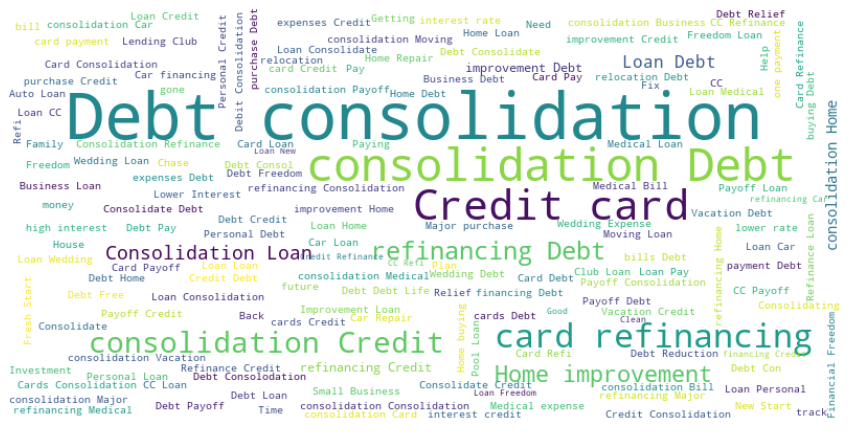

In [216]:
plt.figure(figsize=(15,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observamos que hay mucha variedad en la columna `t_title` y analizando las cadenas notamos que el título de cada préstamo es información que ya se encuentra en la columna `c_purpose`. Por lo tanto, decidimos descartar la columna `t_title`.

In [217]:
#Hacemos una inspección general del otro campo de textos 't_emp_title'. No tiene mucho sentido pues es demasiado variado
df_etiquetado['t_emp_title'].head(15)

0                                     NaN
1                                   Ryder
2                                     NaN
3                     AIR RESOURCES BOARD
5                    Veolia Transportaton
7                         MKC Accounting 
8                                     NaN
9                               Starbucks
10                  Southwest Rural metro
11                                   UCLA
12    Va. Dept of Conservation/Recreation
13                                 Target
14                                  SFMTA
15               Internal revenue Service
16                      Chin's Restaurant
Name: t_emp_title, dtype: object

In [218]:
#Los valores que puede tener parecen ser igual de texto libre
len(df_etiquetado['t_emp_title'].unique())

132762

De manera similar, observamos que la columna `t_emp_title` tiene demasiados valores diferentes para aportar información a nuestro modelo, así que la descartamos.

In [219]:
#Se eliminan nuestras columnas de textos pues su tratamiento sería mucho más costoso que la información que podrían proporcionarnos
df_etiquetado.drop(['t_title', 't_emp_title'], axis=1, inplace=True)

#Tambien se elimina su aparicion en el diccionario del etiquetamiento
new_names_t.pop('title')
new_names_t.pop('emp_title')

't_emp_title'

In [220]:
# Después de todo el proceso de limpieza nuestro dataset tiene la siguiente forma:
df_etiquetado.shape

(252971, 33)

## Consistencia

In [221]:
# Chequemos que tan consistentes son nuestros datos para las variables numericas (v)

columnasv = list(df_etiquetado.filter(like ="v_").columns)

#Buscamos todos los valores que tengan las columnas y que sean vacíos
for i in range(0, len(columnasv)):
  print(columnasv[i])
  print(df_etiquetado[df_etiquetado[columnasv[i]] == "nan"].shape[0])
  print(df_etiquetado[df_etiquetado[columnasv[i]] == ""].shape[0])
  print(df_etiquetado[df_etiquetado[columnasv[i]] == "n a"].shape[0])
  print(df_etiquetado[df_etiquetado[columnasv[i]] == "NAN"].shape[0])

#Notemos que NO tenemos inconsistencias en variables numericas

v_total_rev_hi_lim
0
0
0
0
v_tot_cur_bal
0
0
0
0
v_revol_util
0
0
0
0
v_last_pymnt_amnt
0
0
0
0
v_total_rec_int
0
0
0
0
v_total_pymnt_inv
0
0
0
0
v_loan_amnt
0
0
0
0
v_funded_amnt
0
0
0
0
v_funded_amnt_inv
0
0
0
0
v_int_rate
0
0
0
0
v_installment
0
0
0
0
v_annual_inc
0
0
0
0
v_total_rec_prncp
0
0
0
0
v_dti
0
0
0
0
v_inq_last_6mths
0
0
0
0
v_open_acc
0
0
0
0
v_revol_bal
0
0
0
0
v_total_acc
0
0
0
0
v_total_pymnt
0
0
0
0


In [222]:
# Chequemos que tan consistentes son nuestros datos para las variables categoricas (c)

columnasc = list(df_etiquetado.filter(like ="c_").columns)

#Buscamos todos los valores que tengan las columnas y que sean vacíos
for i in range(0, len(columnasc)):
  print(columnasc[i])
  print(df_etiquetado[df_etiquetado[columnasc[i]] == "nan"].shape[0])
  print(df_etiquetado[df_etiquetado[columnasc[i]] == ""].shape[0])
  print(df_etiquetado[df_etiquetado[columnasc[i]] == "n a"].shape[0])
  print(df_etiquetado[df_etiquetado[columnasc[i]] == "NAN"].shape[0])

#Notemos que SI tenemos inconsistencias en el campo 'c_emp_length'

c_emp_length
9897
0
0
0
v_total_rec_int
0
0
0
0
c_term
0
0
0
0
c_grade
0
0
0
0
c_home_ownership
0
0
0
0
c_verification_status
0
0
0
0
c_loan_status
0
0
0
0
v_total_rec_prncp
0
0
0
0
c_purpose
0
0
0
0
c_zip_code
0
0
0
0
c_addr_state
0
0
0
0
c_initial_list_status
0
0
0
0


In [223]:
#imputamos los valores incosistentes a NaN (numpy format)
columans=list(df_etiquetado.columns)
for i in range(0, len(columans)):
  df_etiquetado[columans[i]] = df_etiquetado[columans[i]].replace(["nan", "n a", " ", "",'n.a.'], np.nan)

In [224]:
#Revisamos nuevamente la completitud de nuestro dataset hasta el momento
completitud(df_etiquetado)

,columna,total,completitud
0,v_total_rev_hi_lim,63708,74.816086
1,v_tot_cur_bal,63708,74.816086
2,c_emp_length,9897,96.087694
3,d_last_pymnt_d,527,99.791676
4,v_revol_util,199,99.921335
5,d_last_credit_pull_d,21,99.991699
6,v_total_rec_prncp,0,100.000000
7,c_purpose,0,100.000000
8,c_zip_code,0,100.000000
9,c_addr_state,0,100.000000


**TODAS CUMPLEN CON NUESTRO CRITERIO INICIAL, ASÍ QUE LAS MANTENEMOS**

No se detectan en primera instancia inconsistencias por datos incoherentes. 

Veamos la correctitud de los tipos de datos:

In [225]:
# Númericas
df_etiquetado.filter(regex="^v_").dtypes

v_total_rev_hi_lim    float64
v_tot_cur_bal         float64
v_revol_util          float64
v_last_pymnt_amnt     float64
v_total_rec_int       float64
v_total_pymnt_inv     float64
v_loan_amnt           float64
v_funded_amnt         float64
v_funded_amnt_inv     float64
v_int_rate            float64
v_installment         float64
v_annual_inc          float64
v_total_rec_prncp     float64
v_dti                 float64
v_inq_last_6mths      float64
v_open_acc            float64
v_revol_bal           float64
v_total_acc           float64
v_total_pymnt         float64
dtype: object

In [226]:
# Categóricas
df_etiquetado.filter(regex="^c_").dtypes

c_emp_length             object
c_term                   object
c_grade                  object
c_home_ownership         object
c_verification_status    object
c_loan_status            object
c_purpose                object
c_zip_code               object
c_addr_state             object
c_initial_list_status    object
dtype: object

In [227]:
# Fechas
df_etiquetado.filter(regex="^d_").dtypes

d_last_pymnt_d          object
d_last_credit_pull_d    object
d_issue_d               object
d_earliest_cr_line      object
dtype: object

In [228]:
# Transformamos las fechas a formato AAAA-MM, para facilitar su posterior tratamiento:
df_etiquetado['d_last_pymnt_d'] = df_etiquetado['d_last_pymnt_d'].apply(transform_date)
df_etiquetado['d_last_credit_pull_d'] = df_etiquetado['d_last_credit_pull_d'].apply(transform_date)
df_etiquetado['d_issue_d'] = df_etiquetado['d_issue_d'].apply(transform_date)
df_etiquetado['d_earliest_cr_line'] = df_etiquetado['d_earliest_cr_line'].apply(transform_date)

## Duplicados

In [229]:
#Vemos el numero de duplicado que tenemos

print(df_etiquetado[df_etiquetado.duplicated()].shape[0])

0


No se encontraron duplicados en primer instancia.

## Normalización

In [230]:
#Veamos los datos que tenemos en el data frame y todos sus valores unicos para saber si es apto para aplicar una normalizacion o tener que borrar 

for i in range(0, len(new_names_c.values())):
  print(list(new_names_c.values())[i])
  print(df_etiquetado[list(new_names_c.values())[i]].nunique())

c_emp_length
10
c_term
2
c_grade
7
c_home_ownership
6
c_loan_status
2
c_purpose
14
c_zip_code
886
c_addr_state
51
c_initial_list_status
2
c_verification_status
3


Empecemos a ver las distribuciones de nuestros valores.Tomaremos como referencia de umbral el 0.1

In [231]:
#La distribución es suficientemente buena pues en este caso es justificable que algunas no rebasen el umbral
df_etiquetado["c_emp_length"].value_counts(1)

10 years    0.316286
1 year      0.155270
2 years     0.096929
3 years     0.083843
5 years     0.074294
4 years     0.066634
6 years     0.060693
7 years     0.057945
8 years     0.048746
9 years     0.039358
Name: c_emp_length, dtype: float64

In [232]:
#La distribución es suficientemente buena
df_etiquetado["c_term"].value_counts(1)

36 months    0.777393
60 months    0.222607
Name: c_term, dtype: float64

In [233]:
#En este caso la distribucion guarada mayor información en los primeros estados
df_etiquetado["c_grade"].value_counts(1)

b    0.300687
c    0.258211
a    0.167197
d    0.160121
e    0.075843
f    0.030280
g    0.007661
Name: c_grade, dtype: float64

In [234]:
#Procedemos a almacenar los estados que no superaron el umbral en otra categoría 'other'

valores_grade = list(df_etiquetado["c_grade"].value_counts().index)
df_etiquetado["c_grade"] = df_etiquetado["c_grade"].replace(valores_grade[4:], "other")
df_etiquetado["c_grade"].value_counts(1)

b        0.300687
c        0.258211
a        0.167197
d        0.160121
other    0.113784
Name: c_grade, dtype: float64

In [235]:
df_etiquetado["c_home_ownership"].value_counts(1)

mortgage    0.493511
rent        0.418850
own         0.086907
other       0.000557
none        0.000170
any         0.000004
Name: c_home_ownership, dtype: float64

In [236]:
# Normalizamos los valores ya que la mayoria de la información esta en los primeros valores del atributo

valores_home = list(df_etiquetado["c_home_ownership"].value_counts().index)
df_etiquetado["c_home_ownership"] = df_etiquetado["c_home_ownership"].replace(valores_home[2:], "other")
df_etiquetado["c_home_ownership"].value_counts(1)

mortgage    0.493511
rent        0.418850
other       0.087639
Name: c_home_ownership, dtype: float64

In [237]:
#La distribución es suficientemente buena
df_etiquetado["c_loan_status"].value_counts(1)

fully paid     0.821134
charged off    0.178866
Name: c_loan_status, dtype: float64

In [238]:
df_etiquetado["c_purpose"].value_counts(1)

debt consolidation    0.586482
credit card           0.197952
home improvement      0.059015
other                 0.056437
major purchase        0.024766
small business        0.018761
car                   0.014413
medical               0.011282
moving                0.008017
wedding               0.007728
house                 0.006530
vacation              0.006277
educational           0.001285
renewable energy      0.001055
Name: c_purpose, dtype: float64

In [239]:
# Observamos que la mayoría de la información se encuentra en las primeras 5 categorías
# agrupamos las restantes en "other"

valores_purpose = list(df_etiquetado["c_purpose"].value_counts().index)
df_etiquetado["c_purpose"] = df_etiquetado["c_purpose"].replace(valores_purpose[5:], "other")
df_etiquetado["c_purpose"].value_counts(1)

debt consolidation    0.586482
credit card           0.197952
other                 0.131786
home improvement      0.059015
major purchase        0.024766
Name: c_purpose, dtype: float64

In [240]:
df_etiquetado["c_zip_code"].value_counts(1)


945xx    0.012990
112xx    0.011195
750xx    0.010938
100xx    0.009970
900xx    0.009780
           ...   
929xx    0.000004
938xx    0.000004
524xx    0.000004
510xx    0.000004
580xx    0.000004
Name: c_zip_code, Length: 886, dtype: float64

Observamos que la variable categórica zipcode contiene muchos valores diferentes y cada uno apareciendo en menos del 1.2% de los registros. Dado que solo se tienen los primeros 3 dígitos del código postal, se decidió que la información que esta variable proporciona puede obtenerse de la variable que contiene el estado.

In [241]:
# Eliminamos la columna zip_code del dataframe
df_etiquetado = df_etiquetado.drop(columns='c_zip_code')

# Eliminamos la columna del diccionario
new_names_c.pop('zip_code')

'c_zip_code'

In [242]:
df_etiquetado["c_addr_state"].value_counts(1)

ca    0.170415
ny    0.084350
tx    0.076463
fl    0.069356
nj    0.037953
il    0.036577
pa    0.033201
ga    0.031680
va    0.031395
oh    0.030588
nc    0.027351
ma    0.024268
az    0.024023
md    0.023746
mi    0.023702
wa    0.023382
co    0.022188
mn    0.017630
mo    0.015630
nv    0.015057
ct    0.014551
or    0.013254
al    0.012440
wi    0.012167
la    0.011669
sc    0.011140
in    0.011068
tn    0.009590
ky    0.008965
ok    0.008424
ut    0.008349
ks    0.008234
ar    0.006934
hi    0.005843
nm    0.005443
nh    0.004538
wv    0.004495
ri    0.004297
dc    0.003309
mt    0.002909
de    0.002637
ak    0.002621
wy    0.002380
sd    0.002150
vt    0.001692
ms    0.001664
ne    0.000150
me    0.000051
nd    0.000032
ia    0.000024
id    0.000024
Name: c_addr_state, dtype: float64

In [243]:
#Normalizamos los valores ya que la mayoria de la información esta en los primeros estados

valores_estados = list(df_etiquetado["c_addr_state"].value_counts().index)
df_etiquetado["c_addr_state"] = df_etiquetado["c_addr_state"].replace(valores_estados[28:], "other")
df_etiquetado["c_addr_state"].value_counts(1)

ca       0.170415
other    0.085164
ny       0.084350
tx       0.076463
fl       0.069356
nj       0.037953
il       0.036577
pa       0.033201
ga       0.031680
va       0.031395
oh       0.030588
nc       0.027351
ma       0.024268
az       0.024023
md       0.023746
mi       0.023702
wa       0.023382
co       0.022188
mn       0.017630
mo       0.015630
nv       0.015057
ct       0.014551
or       0.013254
al       0.012440
wi       0.012167
la       0.011669
sc       0.011140
in       0.011068
tn       0.009590
Name: c_addr_state, dtype: float64

In [244]:
#La distribución es suficientemente buena
df_etiquetado["c_initial_list_status"].value_counts(1)

f    0.719762
w    0.280238
Name: c_initial_list_status, dtype: float64

# Análisis exploratorio

## Variables Categóricas

In [245]:
list(new_names_c.values())

['c_emp_length',
 'c_term',
 'c_grade',
 'c_home_ownership',
 'c_loan_status',
 'c_purpose',
 'c_addr_state',
 'c_initial_list_status',
 'c_verification_status']

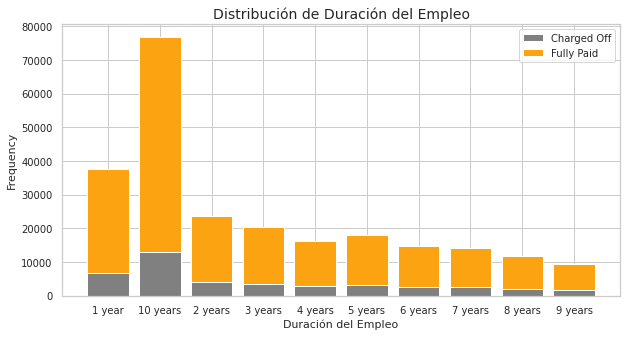

In [246]:
cross_grafica(df_etiquetado,"c_emp_length",'Duración del Empleo',"c_loan_status")

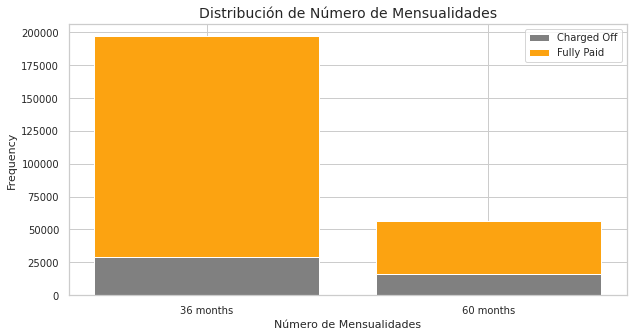

In [247]:
cross_grafica(df_etiquetado,"c_term",'Número de Mensualidades', "c_loan_status")

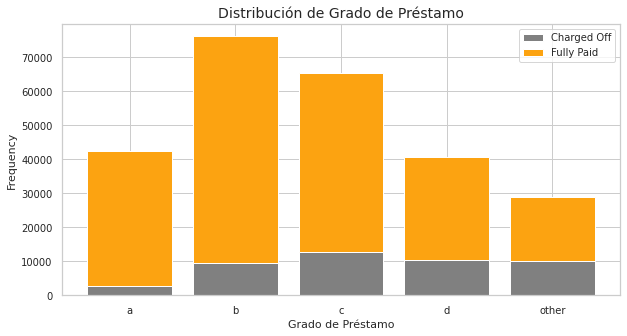

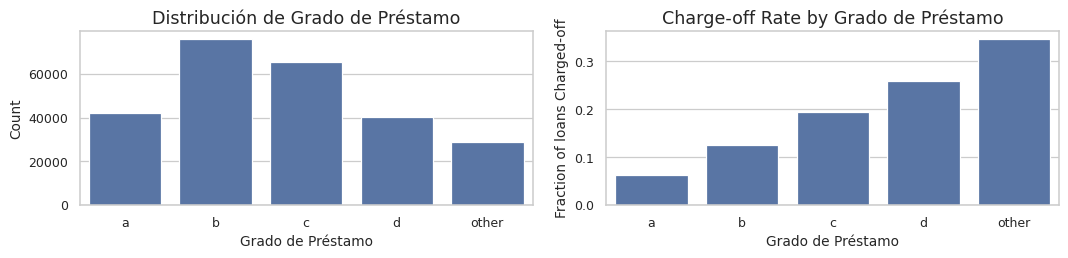

In [248]:
cross_grafica(df_etiquetado,"c_grade",'Grado de Préstamo', "c_loan_status")
grafica_var(df_etiquetado,"c_grade",'Grado de Préstamo', "c_loan_status", False)

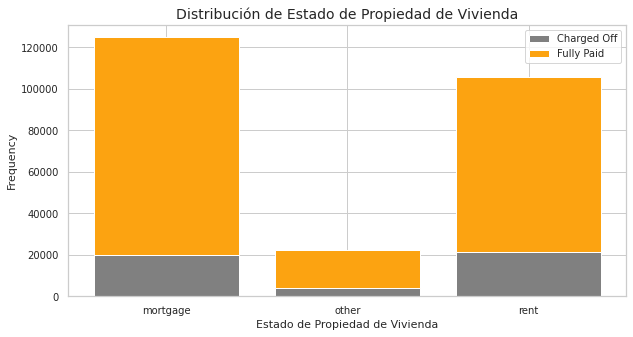

In [249]:
cross_grafica(df_etiquetado,"c_home_ownership",'Estado de Propiedad de Vivienda', "c_loan_status")

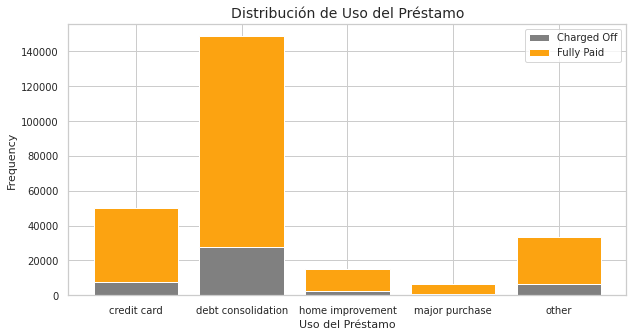

In [250]:
cross_grafica(df_etiquetado,"c_purpose",'Uso del Préstamo', "c_loan_status")

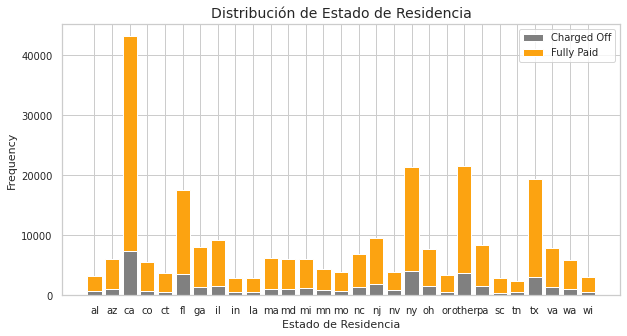

In [251]:
cross_grafica(df_etiquetado,"c_addr_state", 'Estado de Residencia', "c_loan_status")

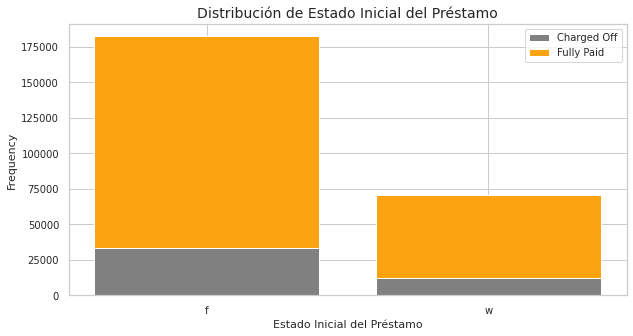

In [252]:
cross_grafica(df_etiquetado,"c_initial_list_status", 'Estado Inicial del Préstamo', "c_loan_status")

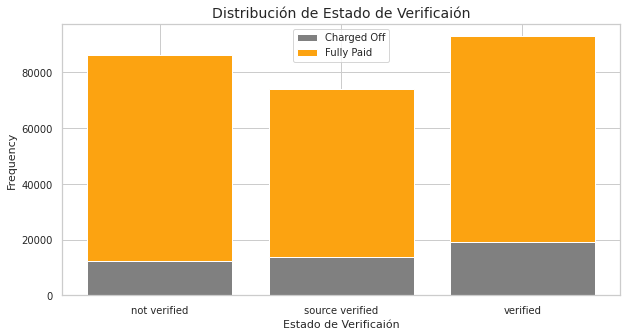

In [253]:
cross_grafica(df_etiquetado,"c_verification_status",'Estado de Verificaión', "c_loan_status")

## Variables Numéricas

In [254]:
list(new_names_v.values())

['v_tot_cur_bal',
 'v_total_rev_hi_lim',
 'v_revol_util',
 'v_open_acc',
 'v_total_acc',
 'v_inq_last_6mths',
 'v_annual_inc',
 'v_last_pymnt_amnt',
 'v_loan_amnt',
 'v_funded_amnt',
 'v_funded_amnt_inv',
 'v_int_rate',
 'v_installment',
 'v_dti',
 'v_revol_bal',
 'v_total_pymnt',
 'v_total_pymnt_inv',
 'v_total_rec_prncp',
 'v_total_rec_int']

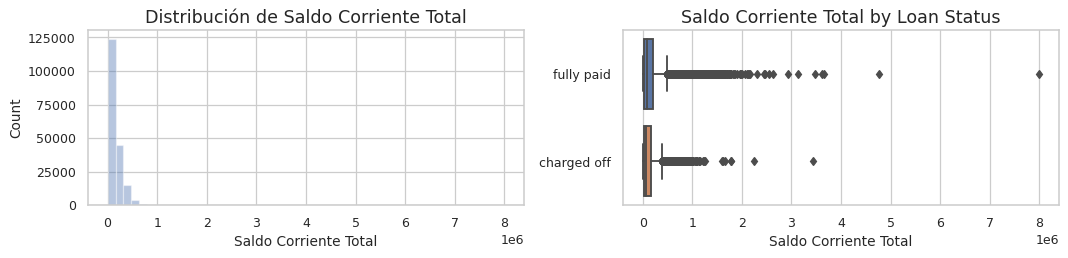

In [255]:
# Graficamos la relación entre los valores de 'v_tot_cur_bal' y el target.
grafica_var(df_etiquetado, 'v_tot_cur_bal', 'Saldo Corriente Total', 'c_loan_status', True)

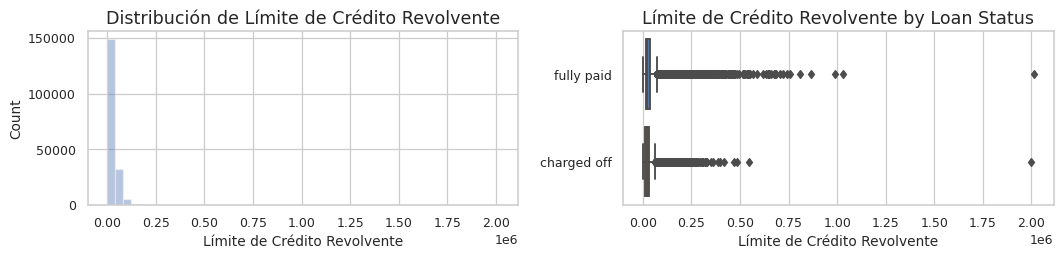

In [256]:
# Graficamos la relación entre los valores de 'v_total_rev_hi_lim' y el target.
grafica_var(df_etiquetado, 'v_total_rev_hi_lim', 'Límite de Crédito Revolvente', 'c_loan_status', True)

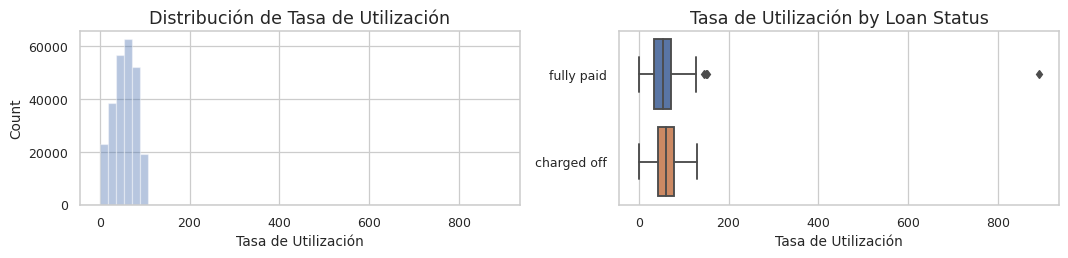

In [257]:
# Graficamos la relación entre los valores de 'v_revol_util' y el target.
grafica_var(df_etiquetado, 'v_revol_util', 'Tasa de Utilización', 'c_loan_status', True)

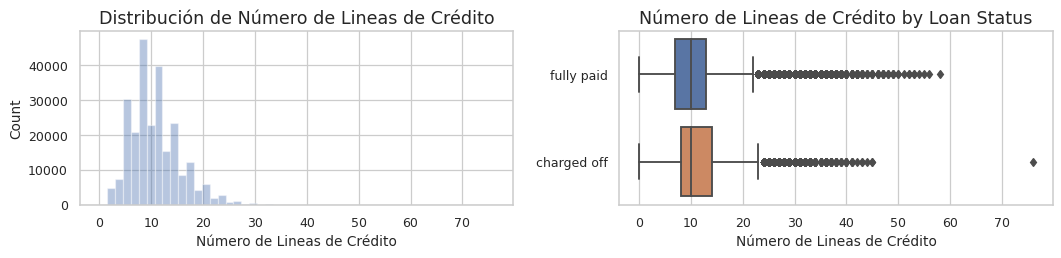

In [258]:
# Graficamos la relación entre los valores de 'v_open_acc' y el target.
grafica_var(df_etiquetado, 'v_open_acc', 'Número de Lineas de Crédito', 'c_loan_status', True)

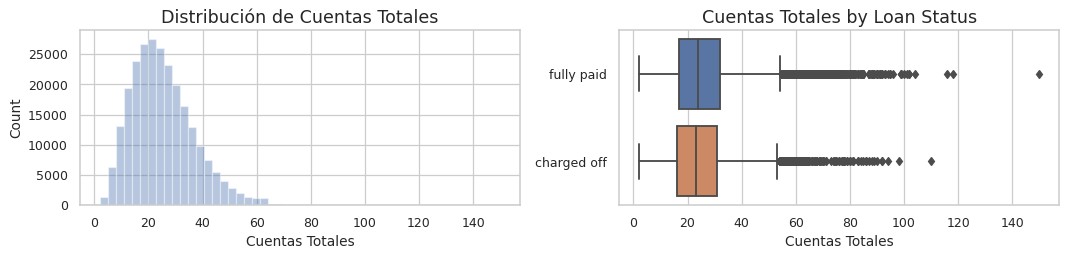

In [259]:
# Graficamos la relación entre los valores de 'v_total_acc' y el target.
grafica_var(df_etiquetado, 'v_total_acc', 'Cuentas Totales', 'c_loan_status', True)

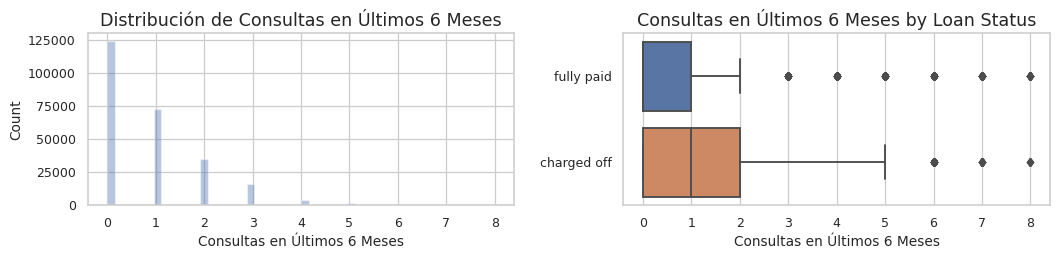

In [260]:
 # Graficamos la relación entre los valores de 'v_inq_last_6mths' y el target.
grafica_var(df_etiquetado, 'v_inq_last_6mths', 'Consultas en Últimos 6 Meses', 'c_loan_status', True)

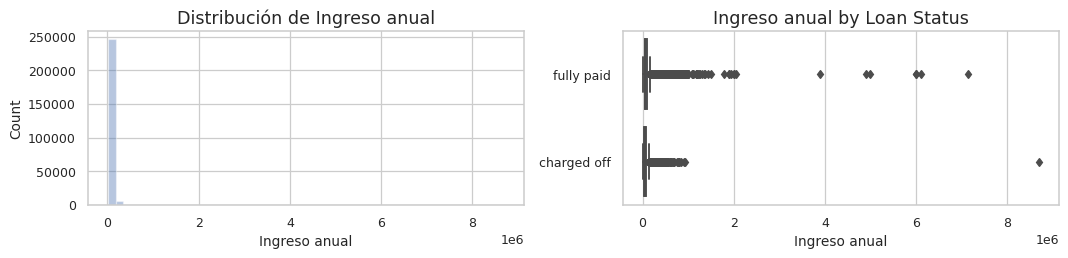

In [261]:
# Graficamos la relación entre los valores de 'v_annual_inc' y el target.
grafica_var(df_etiquetado, 'v_annual_inc', 'Ingreso anual', 'c_loan_status', True)

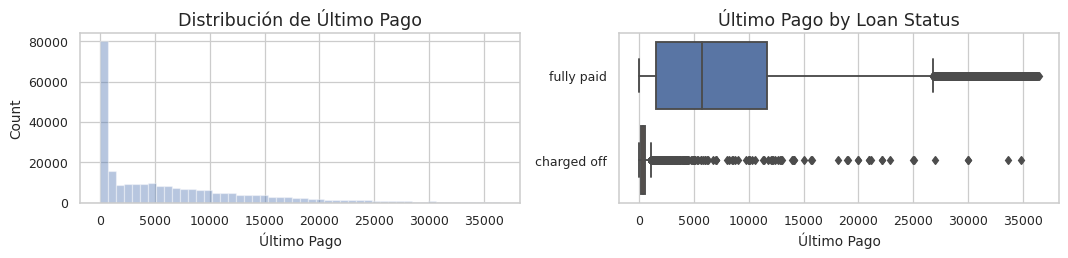

In [262]:
# Graficamos la relación entre los valores de 'v_last_pymnt_amnt' y el target.
grafica_var(df_etiquetado, 'v_last_pymnt_amnt', 'Último Pago', 'c_loan_status', True)

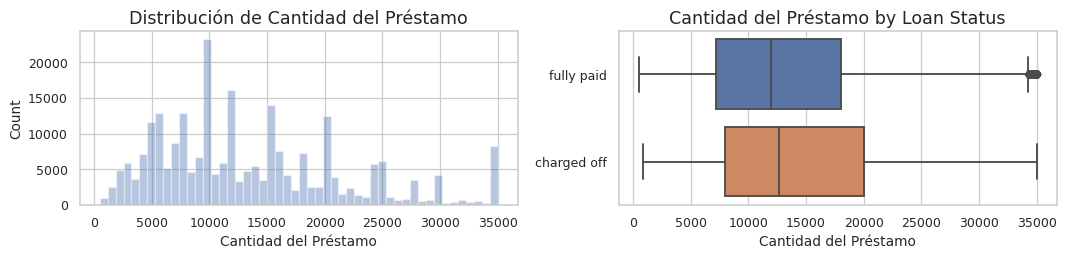

In [263]:
# Graficamos la relación entre los valores de 'v_loan_amnt' y el target.
grafica_var(df_etiquetado, 'v_loan_amnt', 'Cantidad del Préstamo', 'c_loan_status', True)

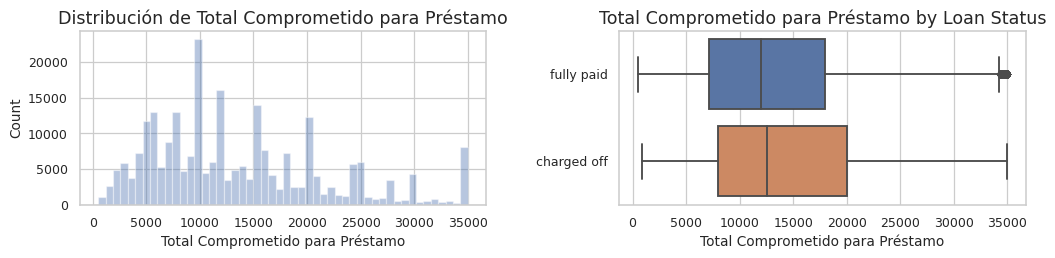

In [264]:
# Graficamos la relación entre los valores de 'v_funded_amnt' y el target.
grafica_var(df_etiquetado, 'v_funded_amnt', 'Total Comprometido para Préstamo', 'c_loan_status', True)

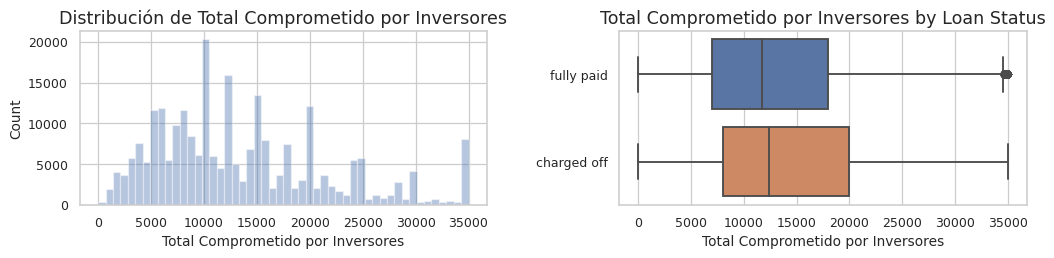

In [265]:
# Graficamos la relación entre los valores de 'v_funded_amnt_inv' y el target.
grafica_var(df_etiquetado, 'v_funded_amnt_inv', 'Total Comprometido por Inversores', 'c_loan_status', True)

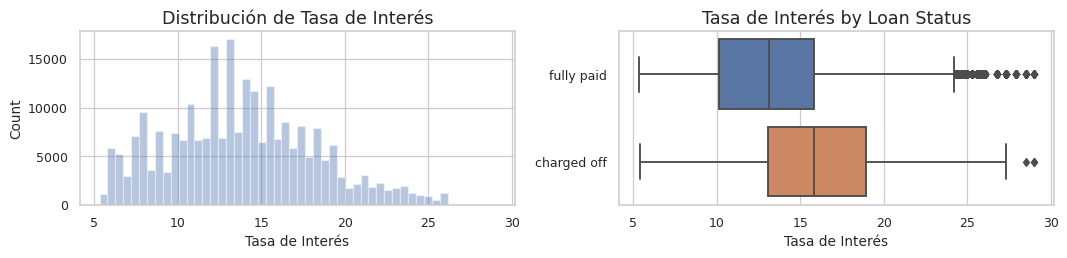

In [266]:
# Graficamos la relación entre los valores de 'v_int_rate' y el target.
grafica_var(df_etiquetado, 'v_int_rate', 'Tasa de Interés', 'c_loan_status', True)

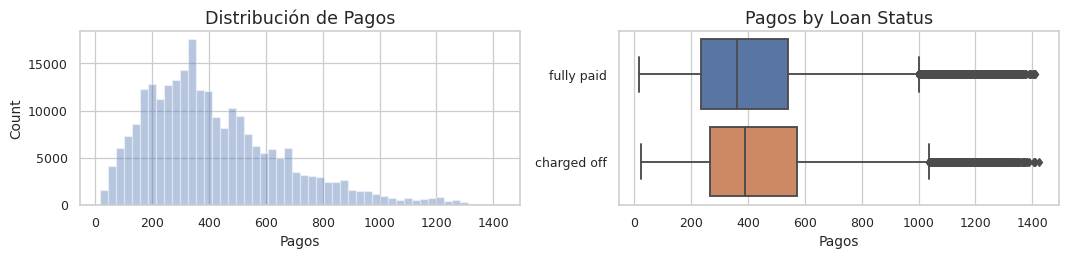

In [267]:
# Graficamos la relación entre los valores de 'v_installment' y el target.
grafica_var(df_etiquetado, 'v_installment', 'Pagos', 'c_loan_status', True)

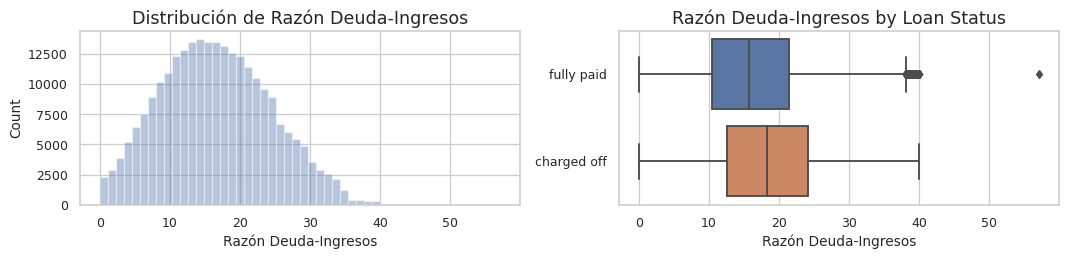

In [268]:
# Graficamos la relación entre los valores de 'v_dti' y el target.
grafica_var(df_etiquetado, 'v_dti', 'Razón Deuda-Ingresos', 'c_loan_status', True)

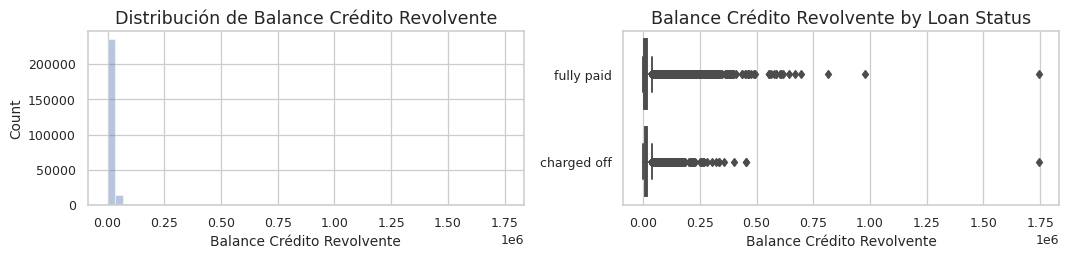

In [269]:
# Graficamos la relación entre los valores de 'v_revol_bal' y el target.
grafica_var(df_etiquetado, 'v_revol_bal', 'Balance Crédito Revolvente', 'c_loan_status', True)

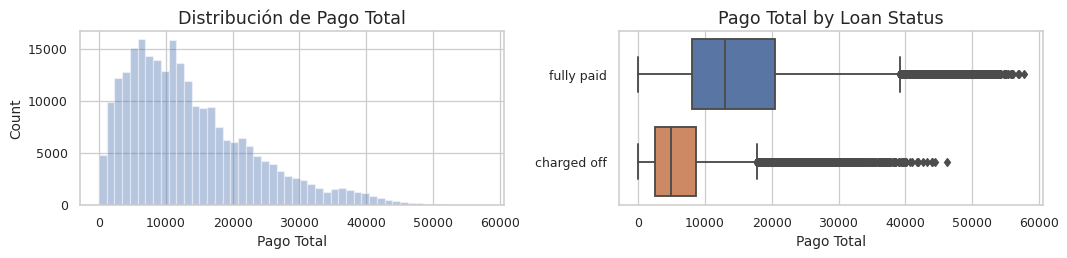

In [270]:
# Graficamos la relación entre los valores de 'v_total_pymnt' y el target.
grafica_var(df_etiquetado, 'v_total_pymnt', 'Pago Total', 'c_loan_status', True)

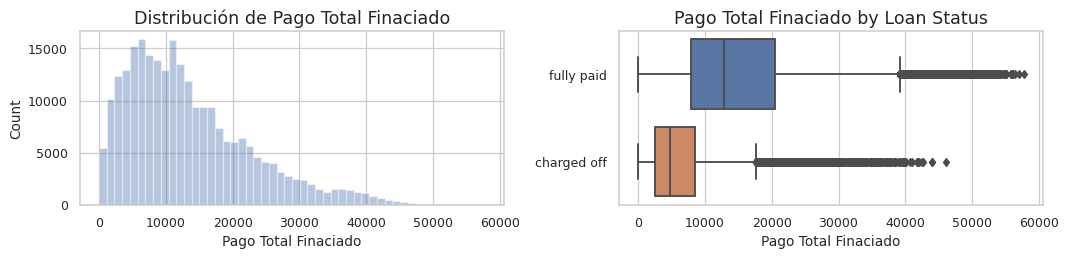

In [271]:
# Graficamos la relación entre los valores de 'v_total_pymnt_inv' y el target.
grafica_var(df_etiquetado, 'v_total_pymnt_inv', 'Pago Total Finaciado', 'c_loan_status', True)

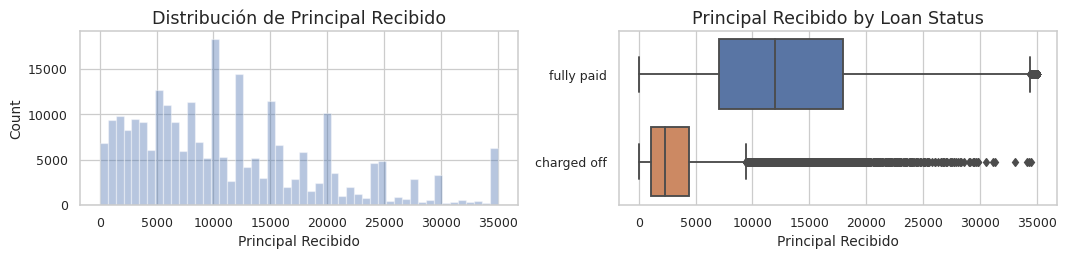

In [272]:
# Graficamos la relación entre los valores de 'v_total_rec_prncp' y el target.
grafica_var(df_etiquetado, 'v_total_rec_prncp', 'Principal Recibido', 'c_loan_status', True)

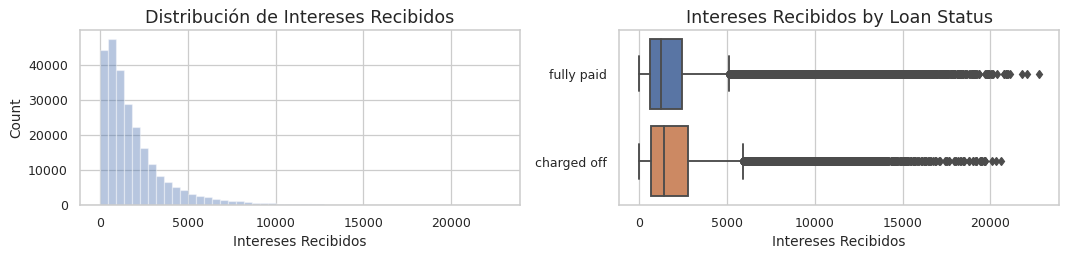

In [273]:
# Graficamos la relación entre los valores de 'v_total_rec_int' y el target.
grafica_var(df_etiquetado, 'v_total_rec_int', 'Intereses Recibidos', 'c_loan_status', True)

## Variables de Fecha

In [274]:
list(new_names_d.values())

['d_last_pymnt_d', 'd_last_credit_pull_d', 'd_earliest_cr_line', 'd_issue_d']

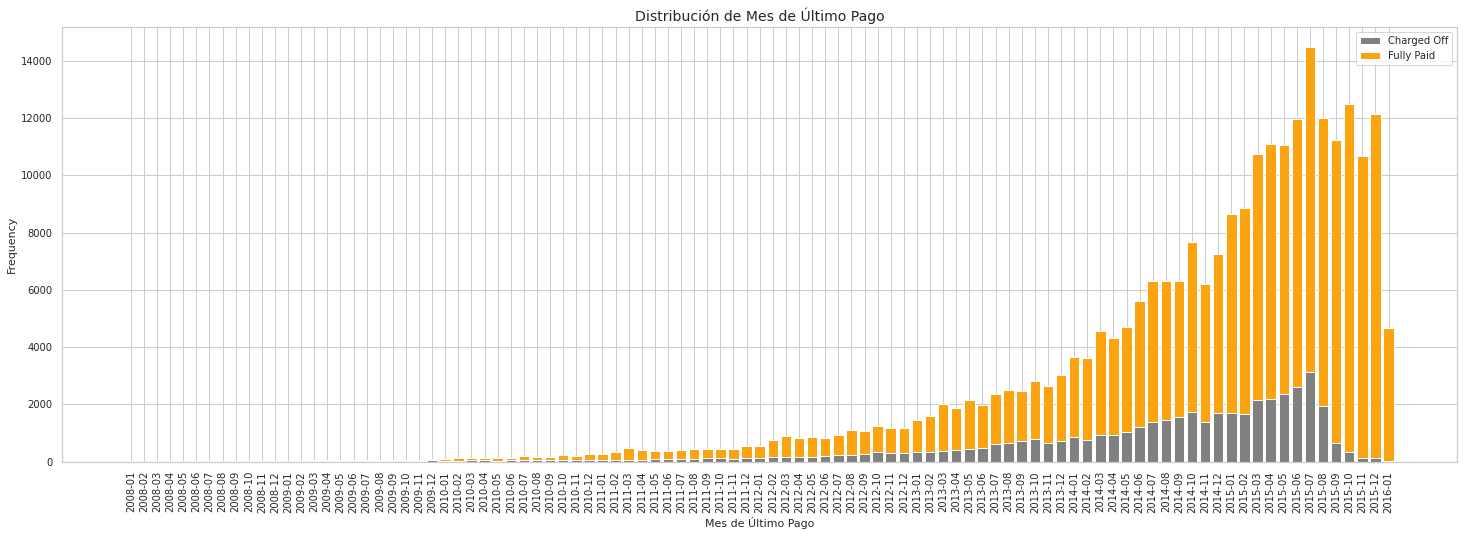

In [275]:
cross_grafica_date(df_etiquetado,"d_last_pymnt_d", 'Mes de Último Pago', "c_loan_status")

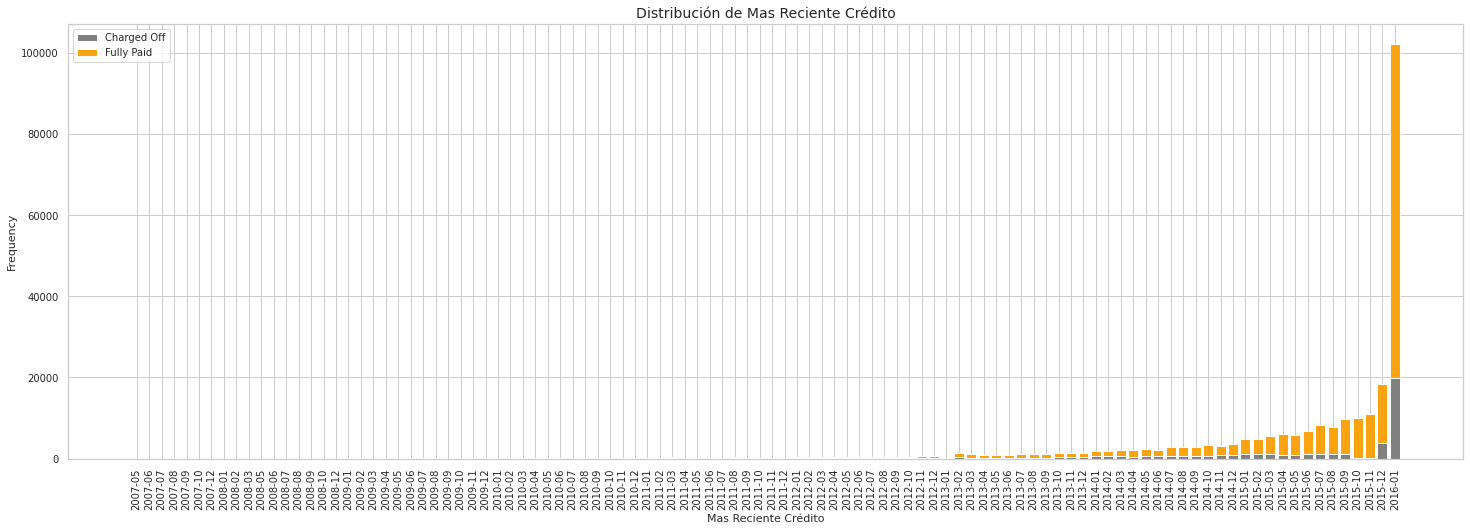

In [276]:
cross_grafica_date(df_etiquetado,"d_last_credit_pull_d", 'Mas Reciente Crédito', "c_loan_status")

In [277]:
# Debido a que el número de valores distintos de la variable 'd_earliest_cr_line', para propósitos de la visualización
# se agrupó por año usando un DataFrame auxiliar.

df_aux_earliest_cr_line = df_etiquetado[['d_earliest_cr_line', 'c_loan_status']]
df_aux_earliest_cr_line['year'] = df_aux_earliest_cr_line['d_earliest_cr_line'].apply(lambda s : int(s[:4]))

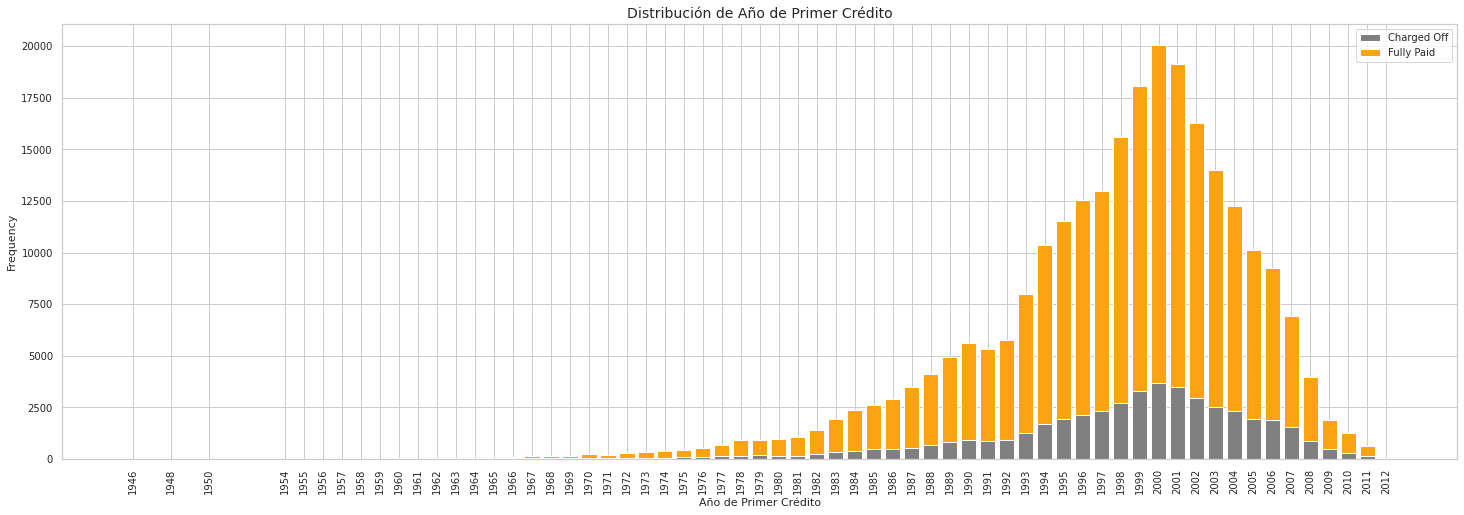

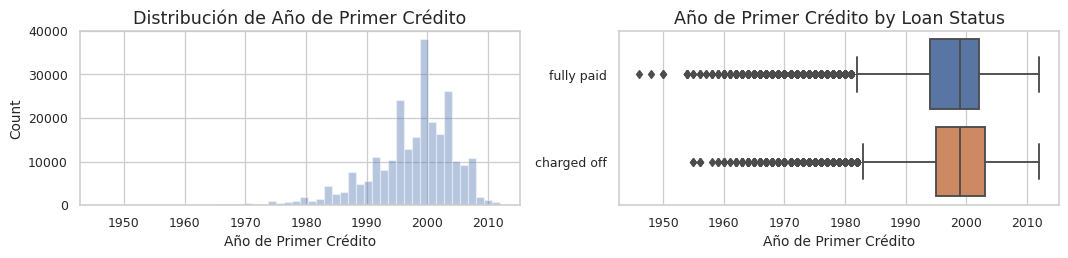

In [278]:
cross_grafica_date(df_aux_earliest_cr_line,"year", 'Año de Primer Crédito',"c_loan_status")
grafica_var(df_aux_earliest_cr_line,"year", 'Año de Primer Crédito',"c_loan_status", True)

# Outliers

In [279]:
#Reseteamos nuestros indices pues se han estado filtrando registros
df_etiquetado=df_etiquetado.reset_index(drop=True)

In [280]:
#Generamos una copia sobre la cual trabajaremos
tratamiento_1= df_etiquetado.copy()

In [281]:
#En este tratamiento veremos unicamente las variables numéricas
v_variables_new=df_etiquetado.filter(regex="^v_").columns.values

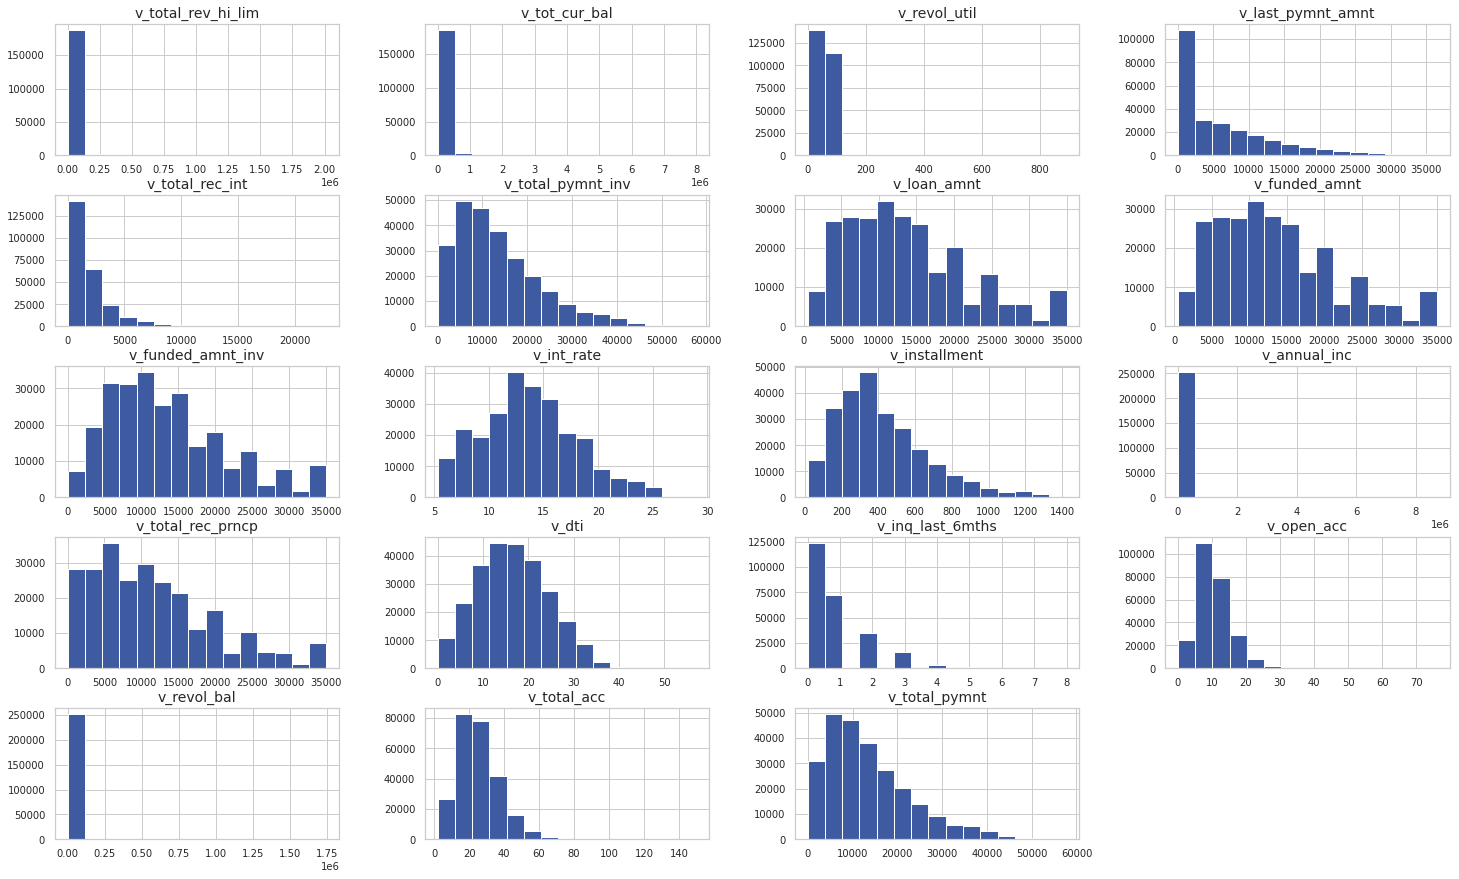

In [282]:
#Graficamos las variables numéricas para observar los outliers
df_etiquetado[v_variables_new].hist(bins=15,figsize=(25,15), color = '#3E5AA0')
plt.savefig('outliers.pdf') 

In [283]:
#Aplicaremos lof, para mejorar nuestros datos con una contamination de 0.02
df_lof=tratamiento_1.filter(like="v_").dropna()


In [284]:
outliers_df = pd.DataFrame()

In [285]:
outliers_df['out'] = [0]*len(df_lof) 

In [286]:
#Aplicamos el modelo

for i in v_variables_new:
  model = LocalOutlierFactor(n_neighbors= 5, metric = "euclidean", contamination = 0.015)
  y_pred = model.fit_predict(df_lof[i].values.reshape(-1,1))
  #Reasignamos la variable
  outliers_df["outlier"]=y_pred
  outliers_df["outlier"] = outliers_df["outlier"].map({-1 : 1, 1: 0})
  outliers_df['out'] = outliers_df['outlier'] | outliers_df['out']
  # Recordemos que los valores negativos son valores atípicos



In [287]:
df_etiquetado = tratamiento_1.iloc[outliers_df[outliers_df['out'] == 0].index]

In [288]:
outliers_df

,out,outlier
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
189138,0,0
189139,0,0
189140,0,0
189141,0,0


In [289]:
df_etiquetado.shape 

(165091, 32)

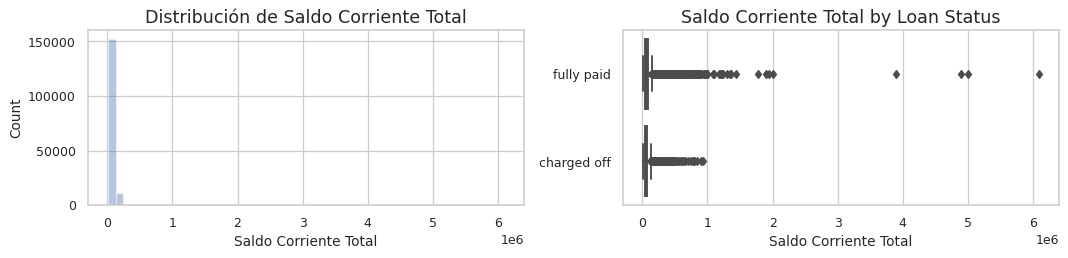

In [290]:
# Graficamos la relación entre los valores de 'v_tot_cur_bal' y el target.
grafica_var(df_etiquetado, 'v_annual_inc', 'Saldo Corriente Total', 'c_loan_status', True)

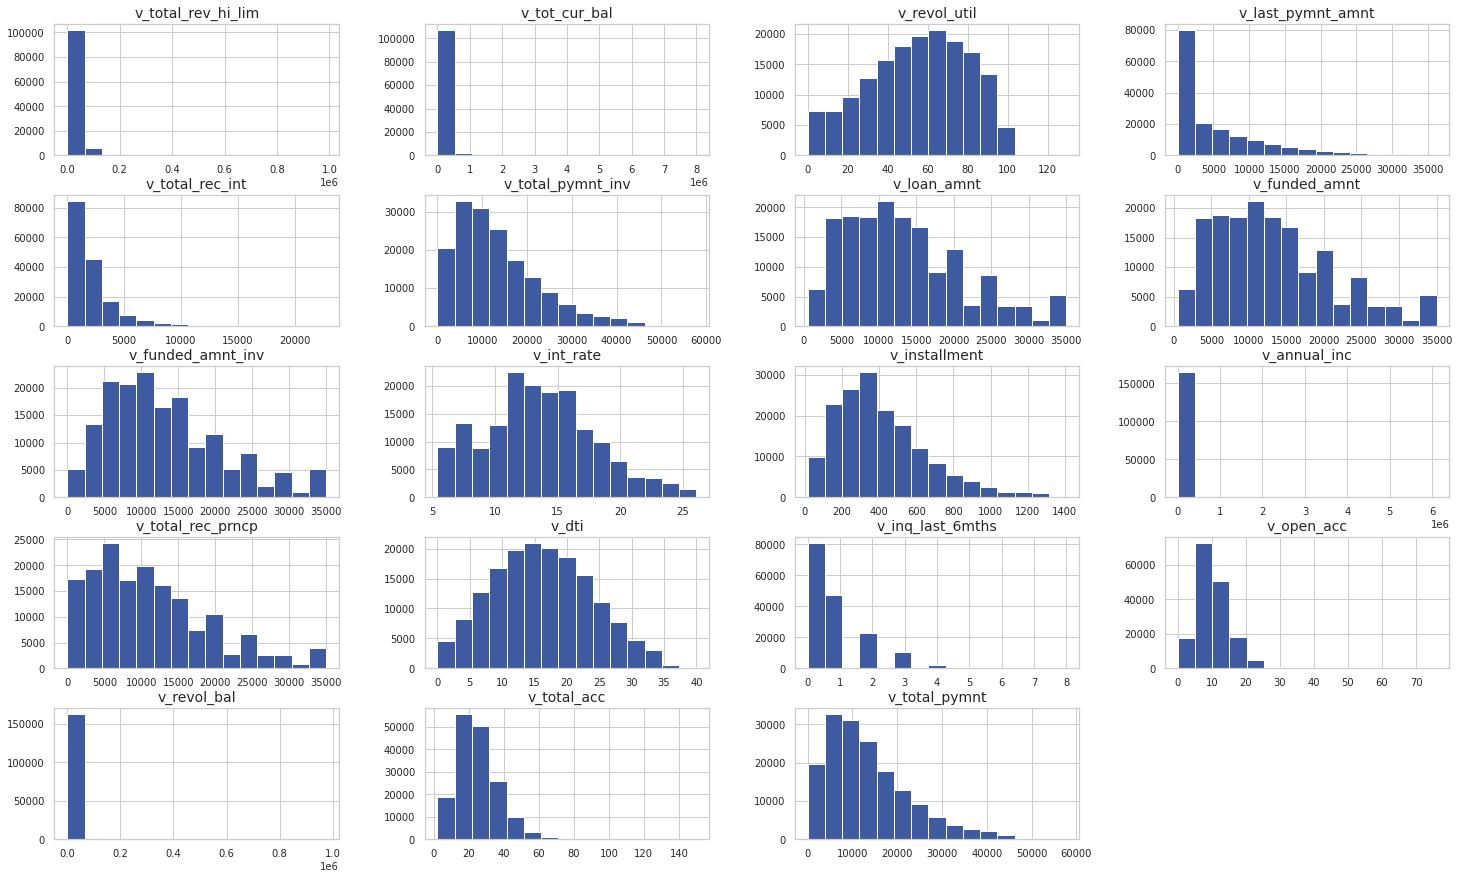

In [291]:
#Graficamos las variables numéricas para observar los outliers
df_etiquetado[v_variables_new].hist(bins=15,figsize=(25,15), color = '#3E5AA0')
plt.savefig('outliers_new.pdf') 

# Missings

In [292]:
#Generamos el dataset de train y test
X_test,X_train=train_test_split(df_etiquetado,train_size=70,stratify=df_etiquetado[["c_loan_status"]],random_state=412)

In [293]:
#Revisamos los missings y vemos que columnas tendremos mayores a 100

completitud(df_etiquetado)

,columna,total,completitud
0,v_total_rev_hi_lim,55989,66.085977
1,v_tot_cur_bal,55989,66.085977
2,c_emp_length,6037,96.343229
3,d_last_pymnt_d,264,99.840088
4,v_revol_util,140,99.915198
5,d_last_credit_pull_d,14,99.991520
6,c_loan_status,0,100.000000
7,v_total_rec_prncp,0,100.000000
8,c_purpose,0,100.000000
9,c_addr_state,0,100.000000


In [294]:
#Trataremos a las variables categóricas
c_variables_new_=df_etiquetado.filter(regex="^c_").columns.values

In [295]:
#Imputamos los datos de las variables categoricas mediante la moda

df_etiquetado['c_emp_length']=imput_moda('c_emp_length',df_etiquetado)

Aceptamos HO(La porporción de categorias es la misma que la general)


Ahora para las variables numéricas checaremos sus estadísticas

In [296]:
# v_total_rev_hi_lim

c_imput('v_total_rev_hi_lim', df_etiquetado)

mean
   Method  p-value  statistic
0    mean      0.0   0.219629
1  median      0.0   0.169583
2    mode      0.0   0.298730


In [297]:
# v_tot_cur_bal

c_imput('v_tot_cur_bal', df_etiquetado)

mean
   Method  p-value  statistic
0    mean      0.0   0.207288
1  median      0.0   0.169573
2    mode      0.0   0.339059


In [298]:
# v_total_rev_hi_lim

c_imput('v_revol_util', df_etiquetado)

mean
   Method  p-value  statistic
0    mean      1.0   0.000447
1  median      1.0   0.000423
2    mode      1.0   0.000841


In [299]:
# Checamos lacompletitud en el dataset de entrenamiento y verificamos que cumple con los estandares establecidos
completitud(X_train)

,columna,total,completitud
0,d_last_pymnt_d,264,99.840020
1,d_last_credit_pull_d,14,99.991516
2,v_total_rev_hi_lim,0,100.000000
3,v_total_acc,0,100.000000
4,v_revol_bal,0,100.000000
5,v_open_acc,0,100.000000
6,v_inq_last_6mths,0,100.000000
7,d_earliest_cr_line,0,100.000000
8,v_dti,0,100.000000
9,c_addr_state,0,100.000000


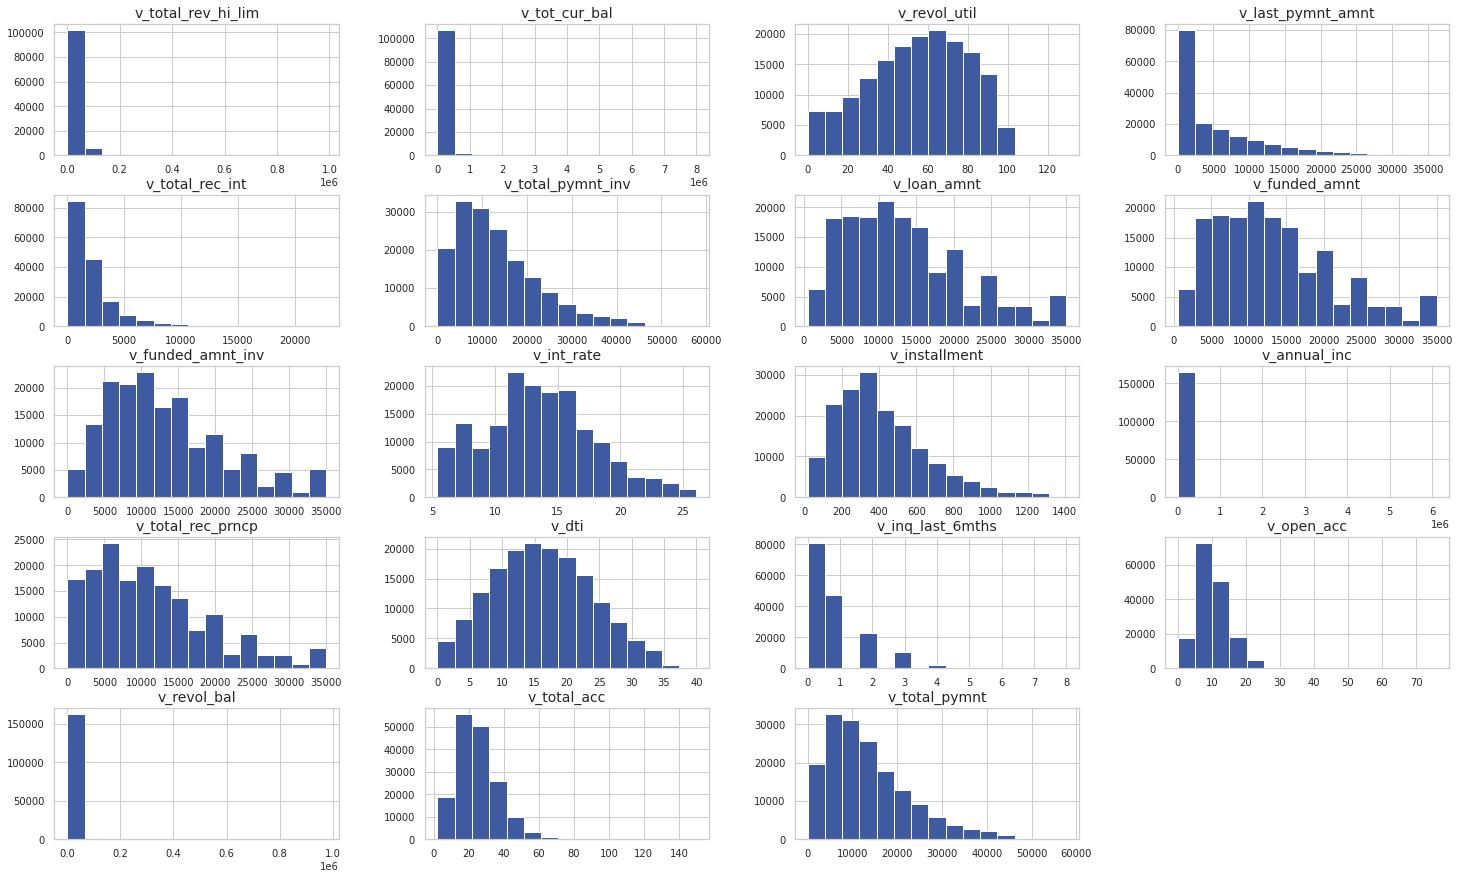

In [300]:
#Vamos a checar el efecto de esta limpieza
df_etiquetado[v_variables_new].hist(bins=15,figsize=(25,15), color = '#3E5AA0')
plt.savefig('outliers_lim.pdf') 

# Ingeniería de variables

## Variables numéricas

In [301]:
#Nuevamente vemos la distribución que tienen nuestros datos en las variables numéricas
X_train[v_variables_new].describe(percentiles=np.arange(0.1,1.1,.1))

,v_total_rev_hi_lim,v_tot_cur_bal,v_revol_util,v_last_pymnt_amnt,v_total_rec_int,v_total_pymnt_inv,v_loan_amnt,v_funded_amnt,v_funded_amnt_inv,v_int_rate,v_installment,v_annual_inc,v_total_rec_prncp,v_dti,v_inq_last_6mths,v_open_acc,v_revol_bal,v_total_acc,v_total_pymnt
count,165021.000000,1.650210e+05,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,1.650210e+05,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000,165021.000000
mean,29342.976828,1.365012e+05,55.030339,5465.279296,2150.052238,13462.388149,13284.362293,13229.742427,13107.968498,13.636345,411.823937,7.137116e+04,11271.007632,16.248606,0.849219,10.698808,15117.283873,24.444683,13590.308989
std,22850.577118,1.228471e+05,24.902298,6703.177419,2202.062342,9441.297343,8000.940873,7967.677341,7988.269501,4.386828,242.794473,5.339117e+04,8095.848030,7.695696,1.059130,4.734888,17581.729413,11.550644,9441.306565
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,500.000000,500.000000,0.000000,5.420000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
10%,10200.000000,1.833800e+04,19.200000,184.280000,357.870000,3310.730000,4500.000000,4450.000000,4200.000000,7.690000,143.590000,3.300000e+04,2200.000000,6.210000,0.000000,5.000000,2896.000000,11.000000,3428.800000
20%,15100.000000,3.345100e+04,32.100000,335.020000,619.660000,5477.330000,6000.000000,6000.000000,6000.000000,9.710000,202.490000,4.000000e+04,4000.090000,9.250000,0.000000,7.000000,5024.000000,14.000000,5585.773796
30%,20400.000000,6.156000e+04,41.600000,519.700000,874.510000,7250.740000,8000.000000,8000.000000,8000.000000,11.140000,262.310000,4.800000e+04,6000.000000,11.680000,0.000000,8.000000,6908.000000,17.000000,7371.400000
40%,27100.000000,1.334640e+05,49.600000,1010.480000,1151.320000,9320.950000,10000.000000,10000.000000,10000.000000,12.120000,316.830000,5.400600e+04,7999.990000,13.830000,0.000000,9.000000,8871.000000,20.000000,9458.100000
50%,29342.976828,1.365012e+05,57.000000,2724.290000,1474.890000,11346.570000,12000.000000,11775.000000,11500.000000,13.350000,361.510000,6.030400e+04,10000.000000,15.930000,1.000000,10.000000,11073.000000,23.000000,11457.760000
60%,29342.976828,1.365012e+05,64.000000,4661.670000,1884.310000,13477.230000,14000.000000,14000.000000,13800.000000,14.330000,420.710000,7.000000e+04,12000.000000,18.120000,1.000000,11.000000,13680.000000,26.000000,13605.227235


Si la distribución de los datos es Normal aplicaremos una estandarización, si en caso contrario no lo es, entonces se utiliza la Normalización MinMax

In [302]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Alpha para prueba de hipótesis
alpha = .05

# Para cada variable
for col in v_variables_new:
  # Determina si los datos se comportan normal
  x = X_train[col]
  k2, p = stats.normaltest(x)
  # En caso de que no, se aplica normalización min-max
  if p < alpha:  
    # print("No es normal")
    scaler = MinMaxScaler()
    scaler.fit(X_train[col].values.reshape(-1, 1))
    X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))
  # En caso de que sí, se aplica estandarización
  else:
    # print("Es normal")
    scaler = StandardScaler()
    scaler.fit(X_train[col].values.reshape(-1, 1))
    X_train[col] = scaler.transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

X_train.head()

,v_total_rev_hi_lim,v_tot_cur_bal,c_emp_length,d_last_pymnt_d,v_revol_util,d_last_credit_pull_d,v_last_pymnt_amnt,v_total_rec_int,v_total_pymnt_inv,v_loan_amnt,v_funded_amnt,v_funded_amnt_inv,c_term,v_int_rate,v_installment,c_grade,c_home_ownership,v_annual_inc,c_verification_status,d_issue_d,c_loan_status,v_total_rec_prncp,c_purpose,c_addr_state,v_dti,d_earliest_cr_line,v_inq_last_6mths,v_open_acc,v_revol_bal,v_total_acc,c_initial_list_status,v_total_pymnt
32746,0.029699,0.017062,9 years,2011-05,0.232612,2011-05,0.218940,0.091946,0.283993,0.402899,0.402899,0.409286,36 months,0.310562,0.331390,b,mortgage,0.014928,not verified,2009-10,fully paid,0.411428,debt consolidation,tx,0.288072,1988-09,0.375,0.276316,0.020247,0.344595,f,0.285479
140923,0.029699,0.017062,10 years,2014-08,0.256569,2015-01,0.007530,0.063512,0.124866,0.223188,0.223188,0.234286,36 months,0.324612,0.184669,b,rent,0.009186,source verified,2012-07,charged off,0.153431,debt consolidation,ca,0.357089,1999-12,0.000,0.118421,0.002759,0.114865,f,0.124866
28237,0.029699,0.017062,3 years,2011-09,0.389490,2016-01,0.124260,0.047753,0.139980,0.188406,0.188406,0.200000,36 months,0.426357,0.161084,c,rent,0.008531,source verified,2010-05,fully paid,0.200000,debt consolidation,fl,0.424856,2000-07,0.000,0.144737,0.018349,0.121622,f,0.139980
124035,0.065182,0.029110,2 years,2015-11,0.423493,2015-11,0.028584,0.293585,0.600357,0.797101,0.797101,0.800000,36 months,0.431686,0.679225,c,rent,0.022310,source verified,2012-10,fully paid,0.799999,debt consolidation,ca,0.337584,1989-09,0.000,0.131579,0.036198,0.101351,f,0.600357
162195,0.034109,0.046676,2 years,2015-12,0.261206,2016-01,0.427372,0.100386,0.351114,0.507246,0.507246,0.514286,60 months,0.318314,0.276220,b,mortgage,0.011647,not verified,2014-11,fully paid,0.514285,debt consolidation,fl,0.521380,2002-02,0.250,0.184211,0.011681,0.317568,w,0.351114


## Variables categoricas

In [303]:
#Primero aplicaremos el tratamiento al conjunto de entrenamiento X_train
X_train

,v_total_rev_hi_lim,v_tot_cur_bal,c_emp_length,d_last_pymnt_d,v_revol_util,d_last_credit_pull_d,v_last_pymnt_amnt,v_total_rec_int,v_total_pymnt_inv,v_loan_amnt,v_funded_amnt,v_funded_amnt_inv,c_term,v_int_rate,v_installment,c_grade,c_home_ownership,v_annual_inc,c_verification_status,d_issue_d,c_loan_status,v_total_rec_prncp,c_purpose,c_addr_state,v_dti,d_earliest_cr_line,v_inq_last_6mths,v_open_acc,v_revol_bal,v_total_acc,c_initial_list_status,v_total_pymnt
32746,0.029699,0.017062,9 years,2011-05,0.232612,2011-05,0.218940,0.091946,0.283993,0.402899,0.402899,0.409286,36 months,0.310562,0.331390,b,mortgage,0.014928,not verified,2009-10,fully paid,0.411428,debt consolidation,tx,0.288072,1988-09,0.375,0.276316,0.020247,0.344595,f,0.285479
140923,0.029699,0.017062,10 years,2014-08,0.256569,2015-01,0.007530,0.063512,0.124866,0.223188,0.223188,0.234286,36 months,0.324612,0.184669,b,rent,0.009186,source verified,2012-07,charged off,0.153431,debt consolidation,ca,0.357089,1999-12,0.000,0.118421,0.002759,0.114865,f,0.124866
28237,0.029699,0.017062,3 years,2011-09,0.389490,2016-01,0.124260,0.047753,0.139980,0.188406,0.188406,0.200000,36 months,0.426357,0.161084,c,rent,0.008531,source verified,2010-05,fully paid,0.200000,debt consolidation,fl,0.424856,2000-07,0.000,0.144737,0.018349,0.121622,f,0.139980
124035,0.065182,0.029110,2 years,2015-11,0.423493,2015-11,0.028584,0.293585,0.600357,0.797101,0.797101,0.800000,36 months,0.431686,0.679225,c,rent,0.022310,source verified,2012-10,fully paid,0.799999,debt consolidation,ca,0.337584,1989-09,0.000,0.131579,0.036198,0.101351,f,0.600357
162195,0.034109,0.046676,2 years,2015-12,0.261206,2016-01,0.427372,0.100386,0.351114,0.507246,0.507246,0.514286,60 months,0.318314,0.276220,b,mortgage,0.011647,not verified,2014-11,fully paid,0.514285,debt consolidation,fl,0.521380,2002-02,0.250,0.184211,0.011681,0.317568,w,0.351114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47119,0.026619,0.025572,3 years,2014-06,0.268934,2016-01,0.017051,0.061357,0.074803,0.507246,0.507246,0.514286,36 months,0.430233,0.432435,c,mortgage,0.019849,source verified,2013-11,charged off,0.083553,debt consolidation,ny,0.353338,2003-08,0.750,0.263158,0.009386,0.250000,f,0.074803
43850,0.010223,0.002171,1 year,2014-12,0.346213,2016-01,0.207718,0.055692,0.195033,0.275362,0.275362,0.285714,36 months,0.399709,0.233037,b,rent,0.010827,not verified,2013-12,fully paid,0.285714,debt consolidation,tx,0.183046,1998-09,0.000,0.078947,0.004633,0.121622,w,0.195033
16637,0.029699,0.017062,10 years,2013-12,0.128284,2016-01,0.239484,0.191734,0.335203,0.420290,0.420290,0.428571,60 months,0.406008,0.238280,c,mortgage,0.008366,verified,2011-03,fully paid,0.428571,debt consolidation,md,0.617654,1984-12,0.375,0.157895,0.095968,0.189189,f,0.335203
117075,0.006478,0.002755,8 years,2015-04,0.693199,2016-01,0.071950,0.090135,0.208611,0.275362,0.275362,0.285714,36 months,0.372578,0.231091,b,rent,0.004265,verified,2012-11,fully paid,0.285714,debt consolidation,other,0.502126,1990-12,0.000,0.105263,0.005886,0.243243,f,0.208611


In [304]:
#A continuación vamos a transformar todas las variables categóricas en numéricas. Primero el campo 'c_emp_length' que contiene formatos tipo "7 years", nos
#quedamos unicamente con la parte numerica y transformamos a enteros
X_train[['c_emp_length','extra']]=X_train['c_emp_length'].str.split(' ', expand=True)
X_train.drop('extra',axis=1, inplace=True)
X_train['c_emp_length']=X_train['c_emp_length'].astype(float)

In [305]:
#Para el campo 'c_term' creamos un valor booleano pues solo tiene dos posibles valores 60 months que cambiamos a 0 y 36 months que cambiamos a 1
X_train['c_term']=X_train['c_term'].map({'60 months': 0.0, '36 months': 1.0})

In [306]:
#Transformamos el campo 'c_addr_state' agrupando los estados por sus regiones establecidas con la siguiente convencion
#Convencion: 0 para zona West,1 para zona Midwest, 2 para zona northeast y 3 para zona south, y 4 para other
X_train['c_addr_state']=X_train['c_addr_state'].map({'ny':2.0,'ca':0.0,'sc':3.0,'il':1.0,'ga':3.0,'pa':2.0,'ma':2.0,'other':4.0,'md':3.0,'az':0.0,'va': 3.0,'fl': 3.0,
                                                     'mo':1.0,'tx':3.0,'or':0.0,'nj':2.0, 'co':0.0,'la':3.0,'ct':2.0,'in':1.0,'oh':1.0,'mn':1.0,'nc':3.0,'al':3.0,'mi':1.0,
                                                     'nv':0.0,'wa':0.0,'wi':1.0,'tn':3.0})

In [307]:
#Realizamos un procedimiento similar para todas las variables categoricas
X_train['c_grade']=X_train['c_grade'].map({'a': 0.0, 'b': 1.0,'c':2.0,'d':3.0,'other':4.0})
X_train['c_home_ownership']=X_train['c_home_ownership'].map({'mortgage': 0.0, 'rent': 1.0,'other':2.0})
X_train['c_verification_status']=X_train['c_verification_status'].map({'verified': 0.0, 'not verified': 1.0,'source verified':2.0})
X_train['c_loan_status']=X_train['c_loan_status'].map({'charged off': 0.0, 'fully paid': 1.0})
X_train['c_purpose']=X_train['c_purpose'].map({'home improvement': 0.0, 'debt consolidation': 1.0,'major purchase':2.0,'credit card':3.0,'other':4.0})
X_train['c_initial_list_status']=X_train['c_initial_list_status'].map({'f': 0.0, 'w': 1.0})

In [308]:
#Se repite el mismo proceso para el conjunto de prueba X_test
X_test[['c_emp_length','extra']]=X_test['c_emp_length'].str.split(' ', expand=True)
X_test.drop('extra',axis=1, inplace=True)
X_test['c_emp_length']=X_test['c_emp_length'].astype(float)

X_test['c_term']=X_test['c_term'].map({'60 months': 0.0, '36 months': 1.0})

X_test['c_addr_state']=X_test['c_addr_state'].map({'ny':2.0,'ca':0.0,'sc':3.0,'il':1.0,'ga':3.0,'pa':2.0,'ma':2.0,'other':4.0,'md':3.0,'az':0.0,'va': 3.0,'fl': 3.0,
                                                     'mo':1.0,'tx':3.0,'or':0.0,'nj':2.0, 'co':0.0,'la':3.0,'ct':2.0,'in':1.0,'oh':1.0,'mn':1.0,'nc':3.0,'al':3.0,'mi':1.0,
                                                     'nv':0.0,'wa':0.0,'wi':1.0,'tn':3.0})

X_test['c_grade']=X_test['c_grade'].map({'a': 0.0, 'b': 1.0,'c':2.0,'d':3.0,'other':4.0})
X_test['c_home_ownership']=X_test['c_home_ownership'].map({'mortgage': 0.0, 'rent': 1.0,'other':2.0})
X_test['c_verification_status']=X_test['c_verification_status'].map({'verified': 0.0, 'not verified': 1.0,'source verified':2.0})
X_test['c_loan_status']=X_test['c_loan_status'].map({'charged off': 0.0, 'fully paid': 1.0})
X_test['c_purpose']=X_test['c_purpose'].map({'home improvement': 0.0, 'debt consolidation': 1.0,'major purchase':2.0,'credit card':3.0,'other':4.0})
X_test['c_initial_list_status']=X_test['c_initial_list_status'].map({'f': 0.0, 'w': 1.0})

##Variables de Fecha

Para las variables de fecha construiremos un nuevo campo que nos ayude a englobar la información de dos campos existintes y así reducir una dimensión nuestro dataset. Los campos 'd_issue_d' y 'd_earliest_cr_line', se refieren a la fecha en el que se financio el préstamo y la fecha en la que se abrió por primera vez una cuenta de crédito para ese cliente. Por lo que, al calcular la diferencia entre ellas sabremos el tiempo que ha pasado desde que el cliente abrió su cuenta hasta que pidio su préstamo.

In [309]:
#Basta con transformar los respectivos campos en tipo de fechas, hacer la diferencia, quedarnos con la parte entera y devolver el resultado dividido en 30 (pues la dimension
#sera de meses). Finalmente nos deshacemos de las primeras dos columnas
X_train['d_months_waiting']=((pd.to_datetime(X_train['d_issue_d'])-pd.to_datetime(X_train['d_earliest_cr_line'])).dt.days)/30
X_train.drop(['d_issue_d','d_earliest_cr_line'], axis=1, inplace=True)

In [310]:
#Eliminamos campos por falta de interpretabilidad
X_train.drop(['d_last_pymnt_d','d_last_credit_pull_d'], axis=1, inplace=True)

In [311]:
#Verificamos que todas nuestras columnas sean numéricas
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165021 entries, 32746 to 32027
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   v_total_rev_hi_lim     165021 non-null  float64
 1   v_tot_cur_bal          165021 non-null  float64
 2   c_emp_length           165021 non-null  float64
 3   v_revol_util           165021 non-null  float64
 4   v_last_pymnt_amnt      165021 non-null  float64
 5   v_total_rec_int        165021 non-null  float64
 6   v_total_pymnt_inv      165021 non-null  float64
 7   v_loan_amnt            165021 non-null  float64
 8   v_funded_amnt          165021 non-null  float64
 9   v_funded_amnt_inv      165021 non-null  float64
 10  c_term                 165021 non-null  float64
 11  v_int_rate             165021 non-null  float64
 12  v_installment          165021 non-null  float64
 13  c_grade                165021 non-null  float64
 14  c_home_ownership       165021 non

In [312]:
#Finalmente se aplica en el conjunto X_test
X_test['d_months_waiting']=((pd.to_datetime(X_test['d_issue_d'])-pd.to_datetime(X_test['d_earliest_cr_line'])).dt.days)/30
X_test.drop(['d_issue_d','d_earliest_cr_line'], axis=1, inplace=True)

X_test.drop(['d_last_pymnt_d','d_last_credit_pull_d'], axis=1, inplace=True)

In [313]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 18887 to 100799
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   v_total_rev_hi_lim     70 non-null     float64
 1   v_tot_cur_bal          70 non-null     float64
 2   c_emp_length           70 non-null     float64
 3   v_revol_util           70 non-null     float64
 4   v_last_pymnt_amnt      70 non-null     float64
 5   v_total_rec_int        70 non-null     float64
 6   v_total_pymnt_inv      70 non-null     float64
 7   v_loan_amnt            70 non-null     float64
 8   v_funded_amnt          70 non-null     float64
 9   v_funded_amnt_inv      70 non-null     float64
 10  c_term                 70 non-null     float64
 11  v_int_rate             70 non-null     float64
 12  v_installment          70 non-null     float64
 13  c_grade                70 non-null     float64
 14  c_home_ownership       70 non-null     float64
 15  

In [314]:
#Checamos la forma de nuestro conjunto de prueba
X_test.shape

(70, 29)

In [315]:
#Checamos la forma del conjunto de entrenamiento
X_train.shape

(165021, 29)